# Synaptic Intelligence 알고리즘 실험 결과 분석

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_csv("../results/eval.csv")
df[:6]

,Unnamed: 0,task1,task2,task3,task4,task5,task6
0,baseline_01@task1,0.787792,0.037143,0.139481,-0.028951,0.066434,0.087273
1,baseline_01@task2,0.506623,0.693247,0.056753,0.105734,0.125874,0.102987
2,baseline_01@task3,0.253117,0.380779,0.684675,0.112028,-0.031189,0.031688
3,baseline_01@task4,0.369351,0.432727,0.460390,0.736364,0.170350,0.045195
4,baseline_01@task5,0.308442,0.324675,0.334545,0.510490,0.748951,0.058052
5,baseline_01@task6,0.361688,0.450909,0.328052,0.376224,0.506294,0.742857


### 시각화

In [3]:
from report_utils import visualization

### Epoch에 따른 성능 비교

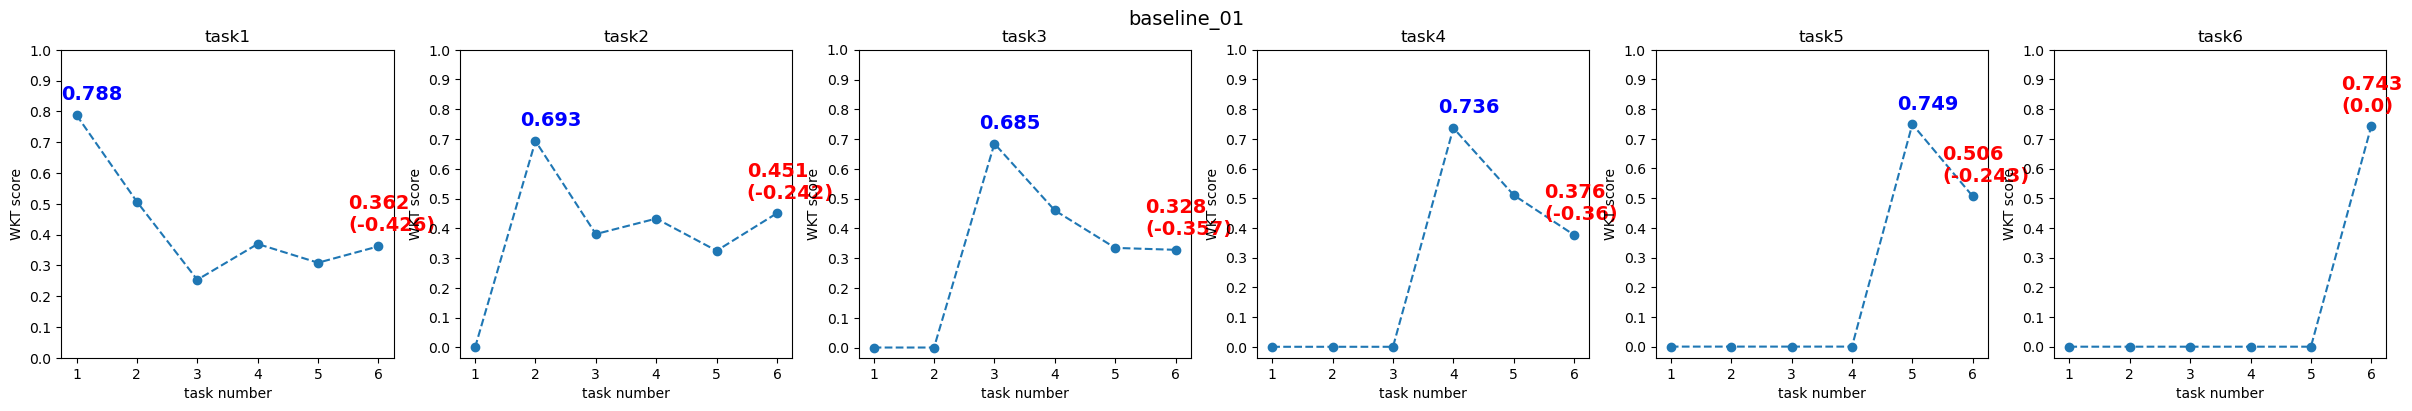

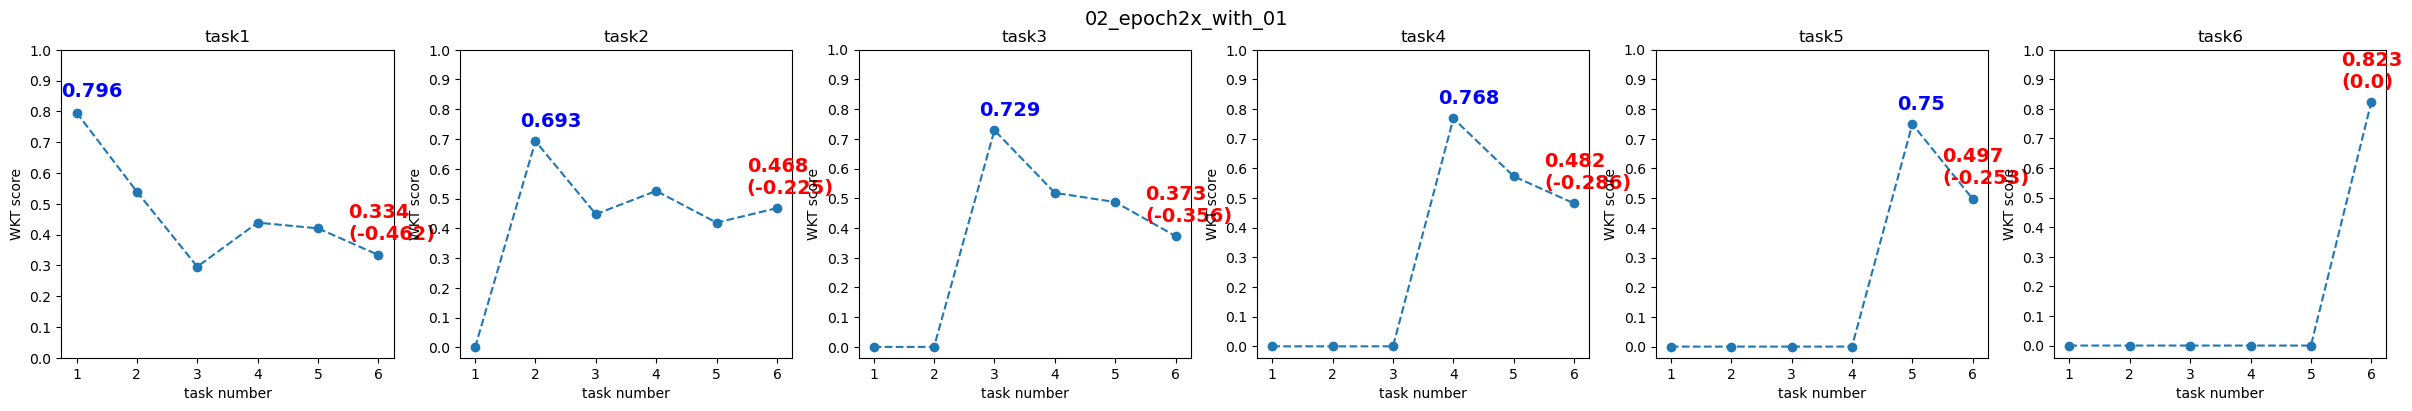

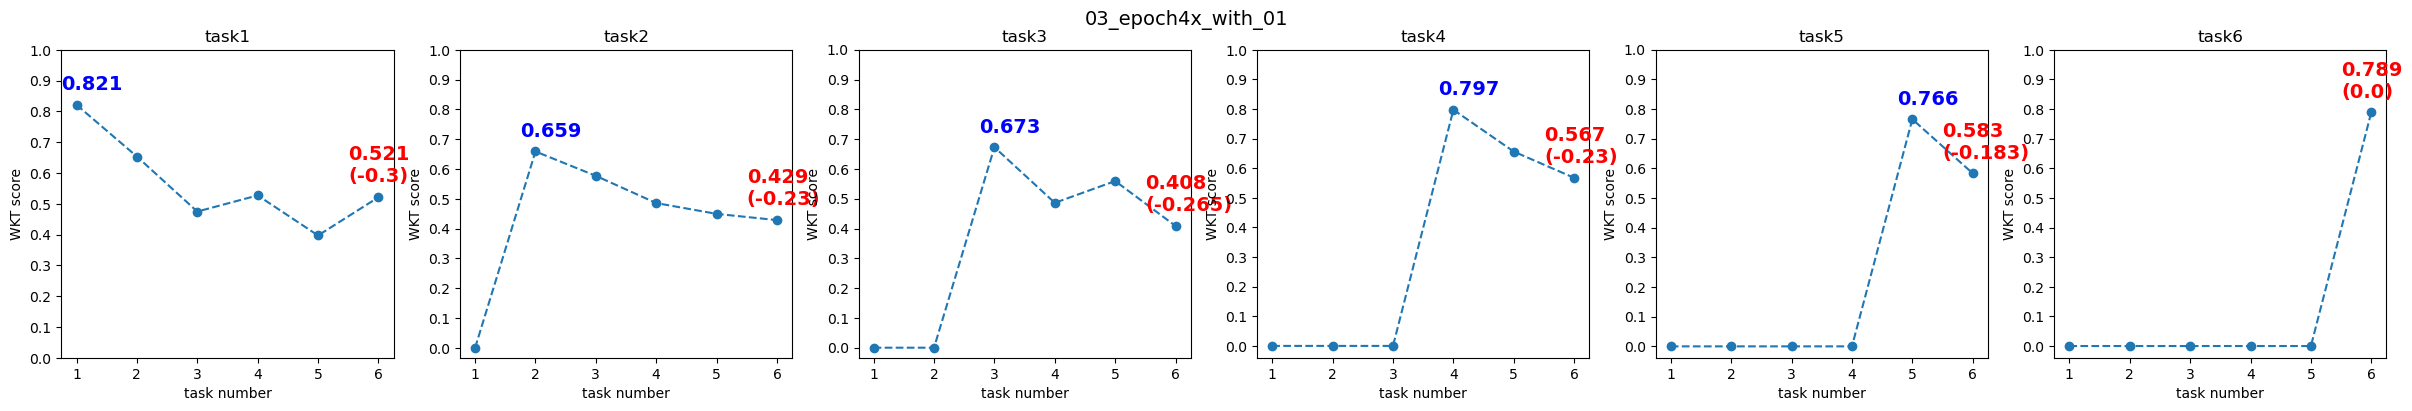

In [4]:
df_epoch = df[:18]
for i in range(0, len(df_epoch), 6):
    visualization(df_epoch[i:i + 6])

- 위에서부터 epoch을 20, 40, 80으로 설정한 뒤 실험한 결과
- epoch을 높일수록 validation wkt score가 높아지는 경향을 보였음. 따라서 이후 실험은 epoch을 80으로 고정하고 진행함

### `corr_thres`에 따른 성능 비교

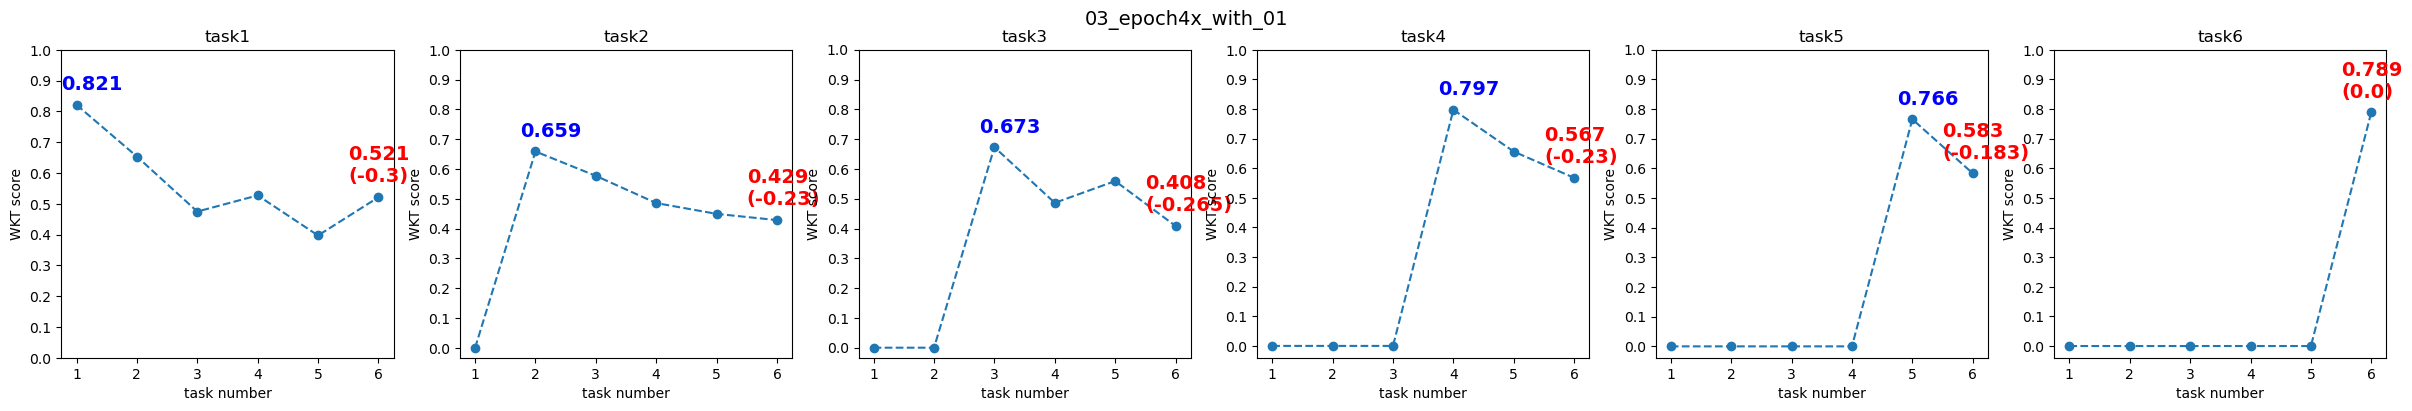

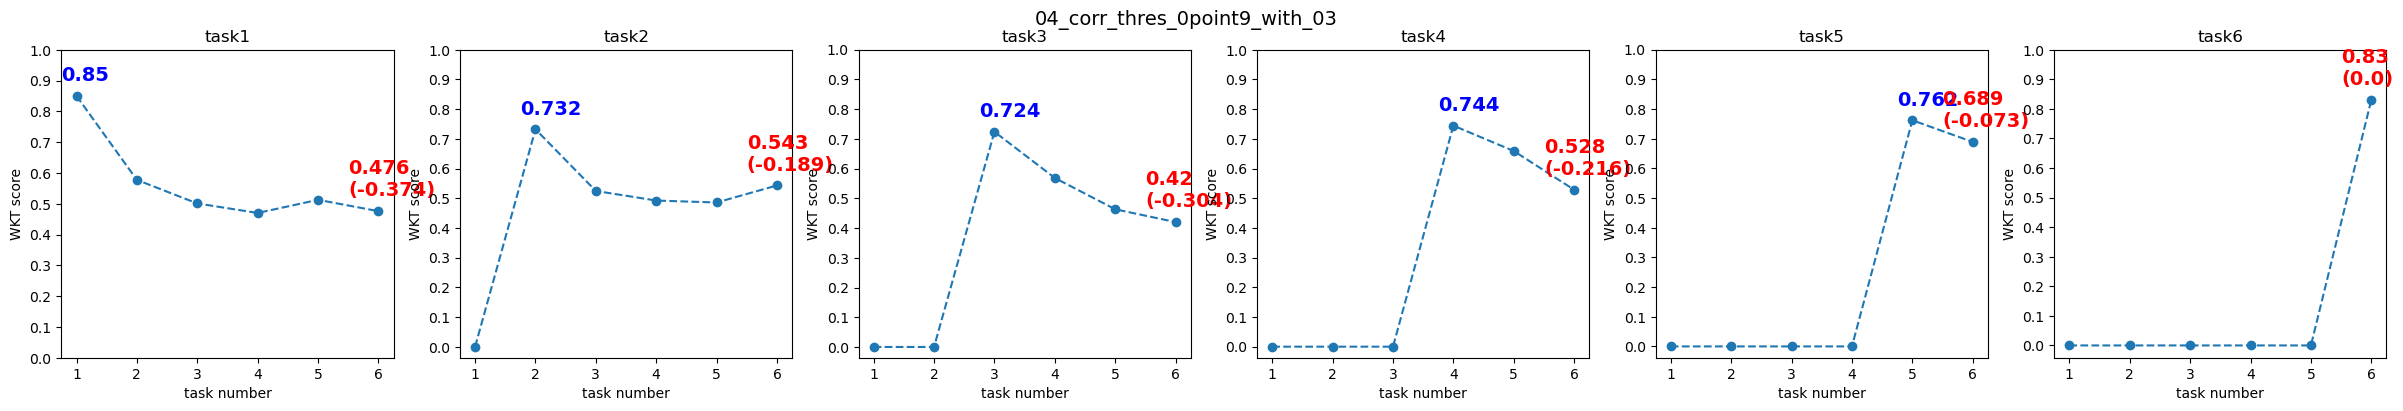

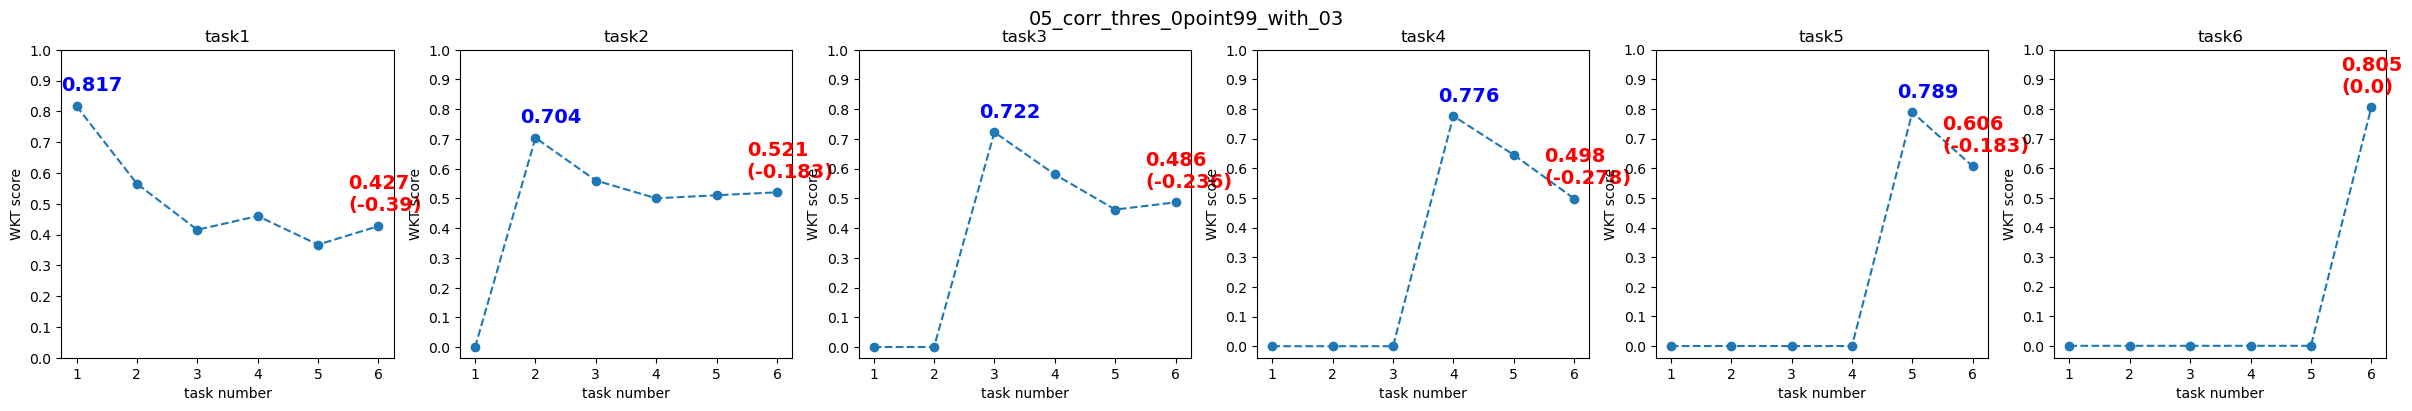

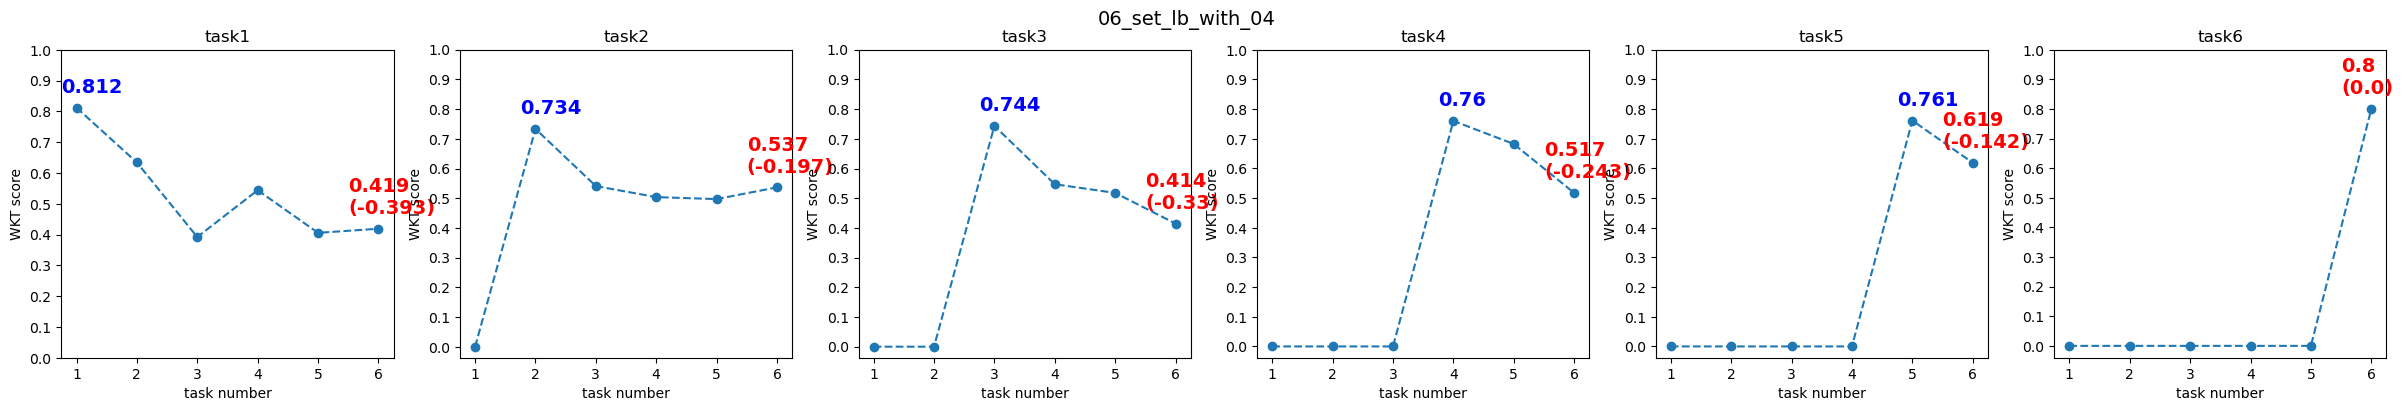

In [5]:
corr_thres_df = df[12:36]
for i in range(0, len(corr_thres_df), 6):
    visualization(corr_thres_df[i:i + 6])

- ranking data를 증강할 때 사용하는 `corr_thres` 값을 변경해보았음.
- 위에서부터 차례대로 `0.7`, `0.9`, `0.99`, (`0.45`, `0.9`)를 사용하였음.

- `0.9`까지 높였을 때 성능이 가장 좋았으며, `0.99`까지 높였을 때는 성능이 오히려 떨어졌음.
- 유사도가 너무 높은 아이템들로 데이터를 증강하는 경우, 코디 조합 간에 순위를 판별하는 것이 힘들어져 성능이 떨어지는 것으로 판단하였음.

- 학습 데이터는 (발화문 데이터, 코디 조합, 조합 순위) 형식으로 구성되어있음.
- 데이터 증강은 이 중 코디 조합과 조합 순위에 적용됨. 다시 말해 데이터를 증강하더라도 발화문 데이터는 고정되어있다는 얘기임.
- 따라서 코디 조합을 증강하는 방식에 있어 조심스러울 필요가 있음.
- 그러나 기존 증강 코드는 유사도가 낮은 아이템들도 증강에 사용할 수 있도록 구현되어있음.
- 만약 유사도가 낮은 아이템이 증강에 사용되는 경우, 대화의 맥락과는 관계없는 불필요한 코디 조합이 만들어질 가능성이 있음.
- 불필요한 코디 조합이 만들어지는 것은 괜찮을 수 있음. 그러나, 학습 또는 평가 데이터에 존재하는 코디 조합들에 그런 데이터들이 없다면 문제가 생길 수 있다고 판단함.
- 따라서 `06_set_lb_with_04` 실험에선 lower bound 설정을 통해 이러한 문제점을 완화하고자 했음. 그러나 전체적으로 성능이 떨어짐

- 본 task에서 데이터를 증강할 때 핵심 포인트는, **대화의 맥락을 고려하여 코디 조합을 생성하되 코디 조합 간의 차이는 분명**해야 한다는 것임.
- **따라서 코디 조합을 인위적으로 생성하는 것에 대해 고민해볼 생각임. -> EDA를 통해 추천한 코디 조합 간에 유사도 차이 정도를 판단해보는 것도 좋을듯.**

### `drop_ratio` 변경

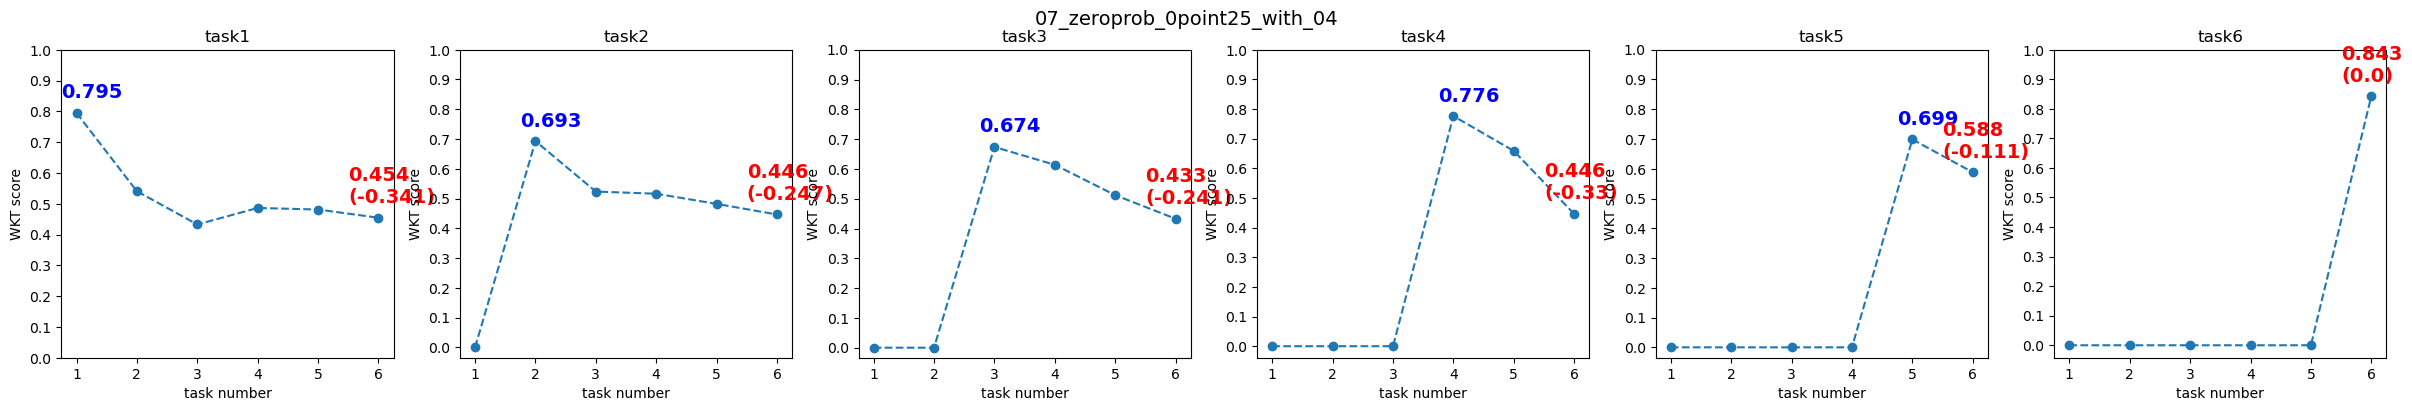

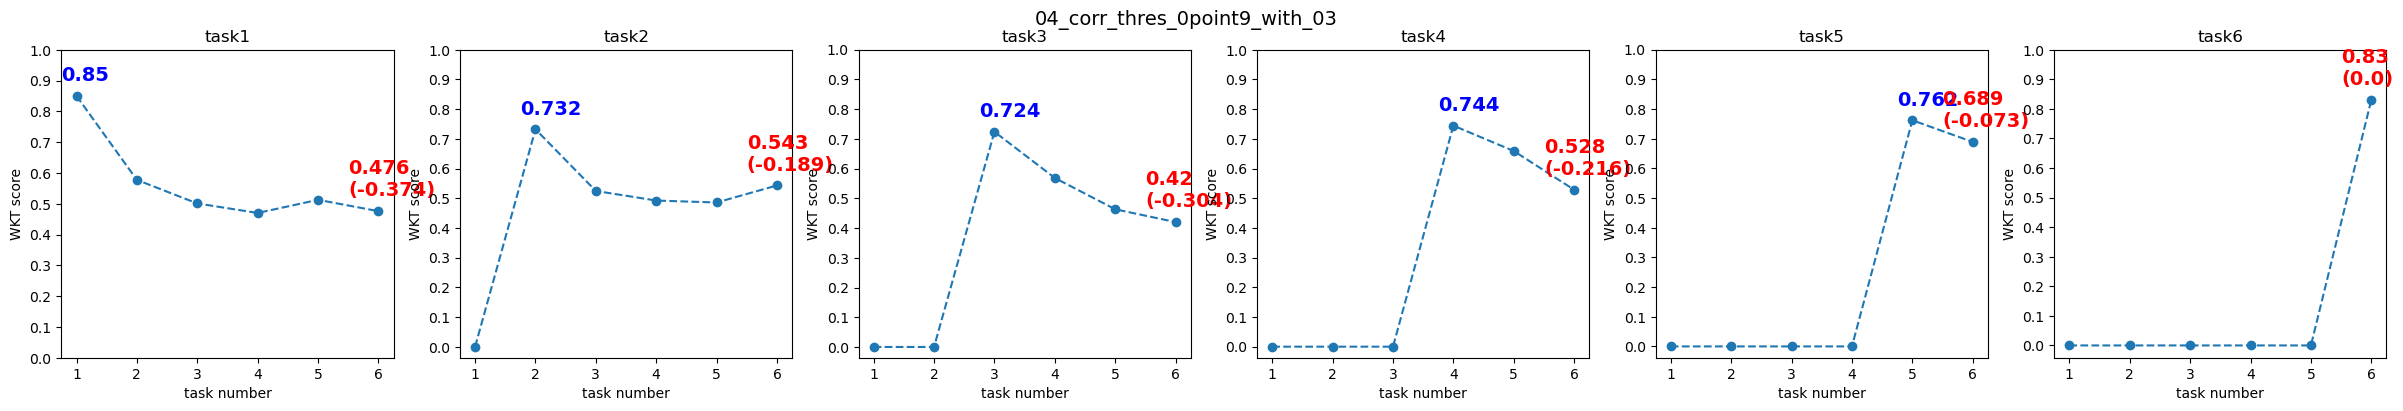

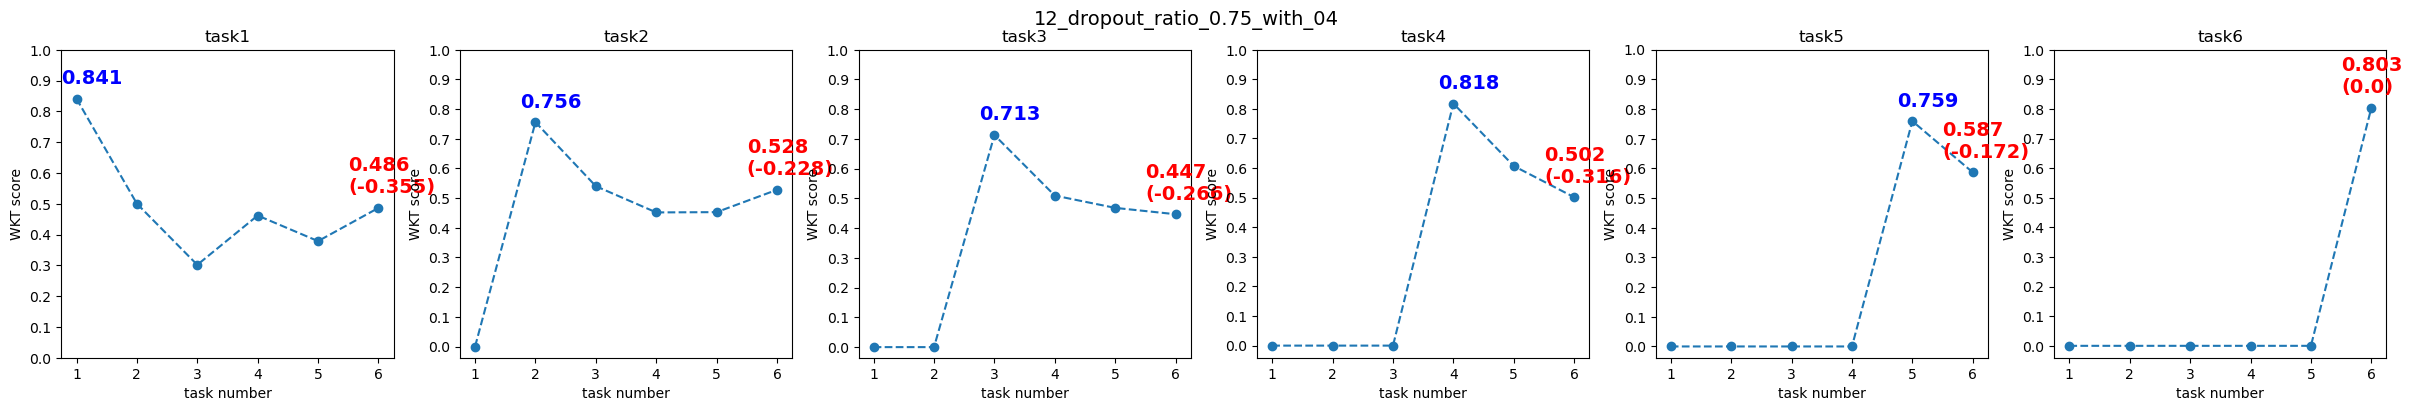

In [6]:
dropout_df = pd.concat([df[36:42], df[18:24], df[66:72]])
for i in range(0, len(dropout_df), 6):
    visualization(dropout_df[i:i + 6])

- continual learning 시나리오에서 dropout이 필요한 이유에 대해 생각해보았음.
- 이상적인 SI 알고리즘 동작은, 모델을 학습하는 과정에서 **특정 파라미터만 주로 사용**되는 것임.
- 그러나, 아무런 제한 없이 모델을 학습하는 경우 **모든 파라미터가 최적화에 사용**됨.
- 특히 본 task는 6개의 데이터셋을 순차적으로 학습해야하는 만큼, 모든 파라미터를 사용하는 경우 수렴 자체가 어려워질 것임. SI 알고리즘의 원리 상 새로운 데이터셋을 학습하는 과정이 누적될수록 파라미터의 변화를 억제하기 때문임.
- 따라서 dropout 적용을 통해 학습에 사용할 수 있는 파라미터를 제한하는 것으로 분석함.

- 다만 dropout을 적용할 비율에 대해서는 고민해볼 필요가 있다고 생각하였음. 따라서 본 실험을 진행하였으나, 동일한 아키텍처에서 dropout 비율을 `0.25`로 낮췄을 때 성능이 전체적으로 떨어지는 모습을 보임.

- 이론적으로는 dropout 없이 사용하는 게 맞기 때문에, 이를 삭제하고 실험해볼 생각
- 추후에 아키텍처를 변경했을 때, dropout의 비율을 재조정해볼 필요는 있다고 판단하여 관련 실험을 진행할 생각 (+ [dropconnect](https://deepestdocs.readthedocs.io/en/latest/004_deep_learning_part_2/0042/))

### PolicyNet 구조 변경

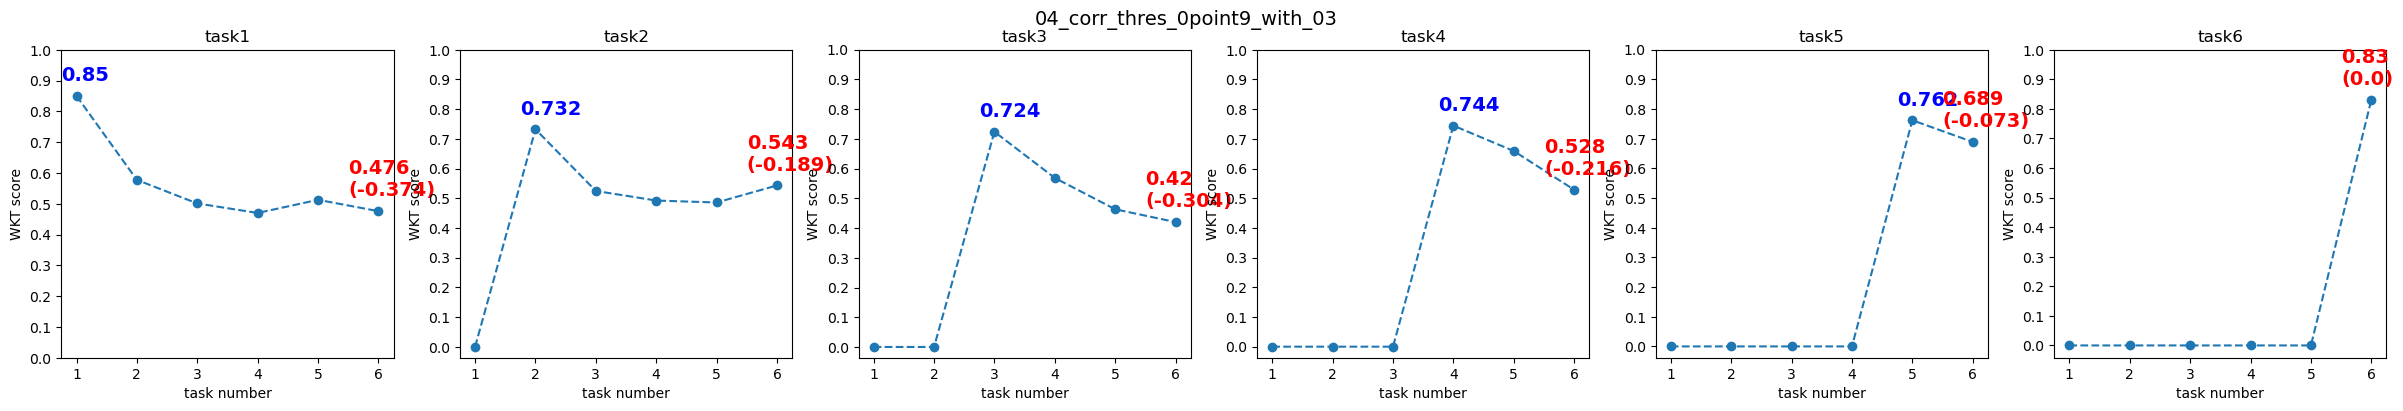

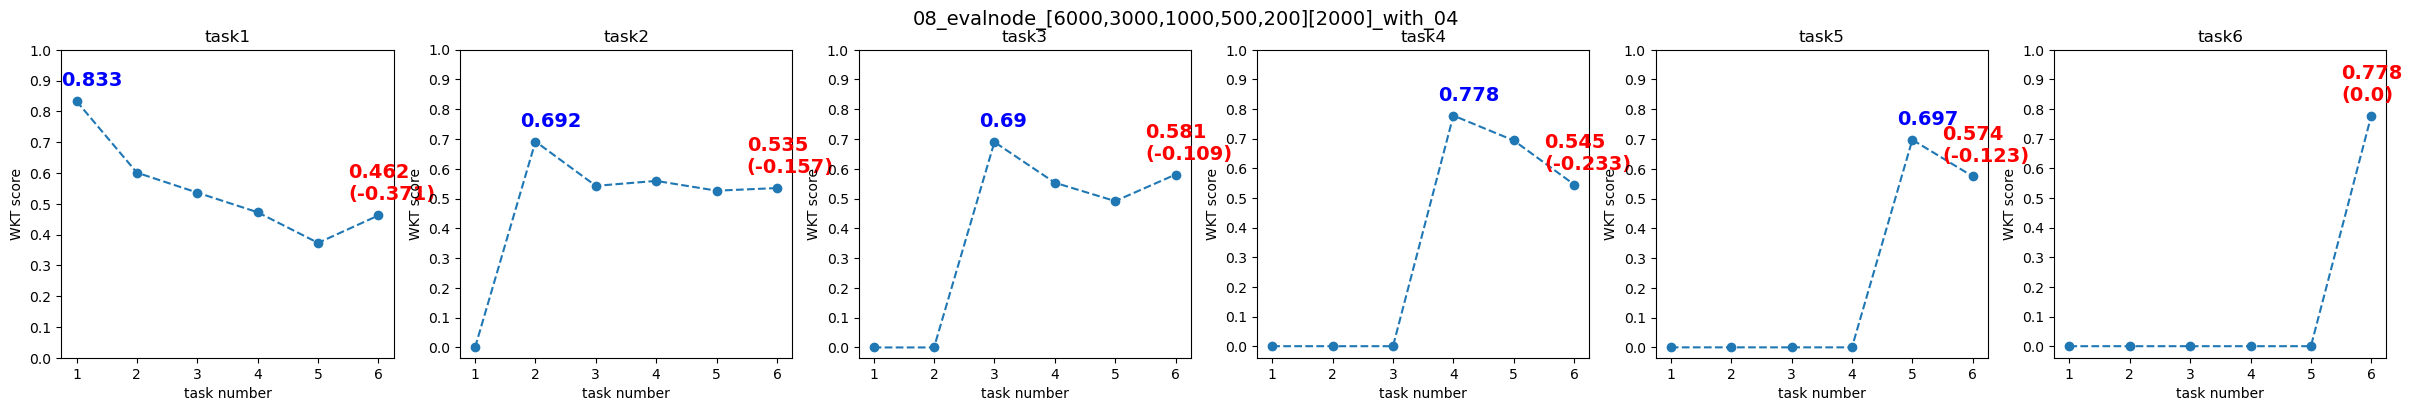

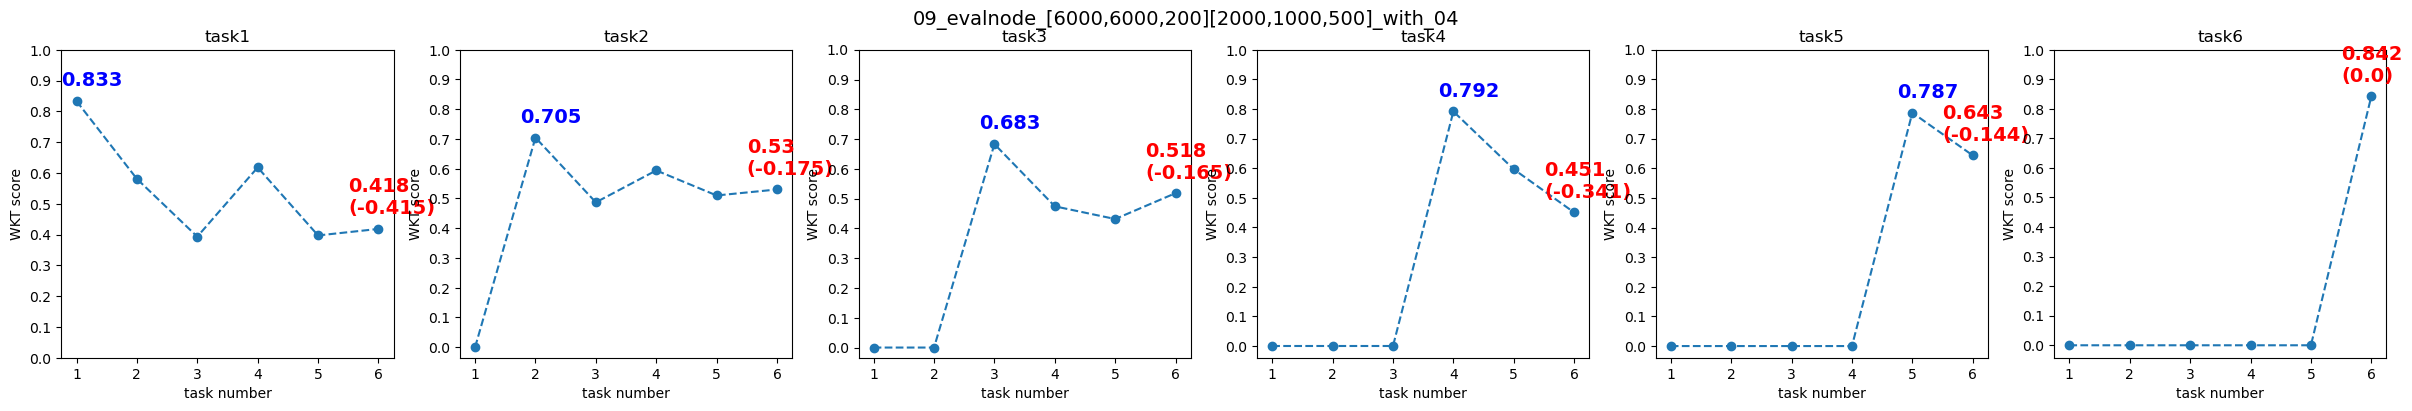

In [7]:
policy_df = pd.concat([df[18:24], df[42:54]])
for i in range(0, len(policy_df), 6):
    visualization(policy_df[i:i + 6])

- PolicyNet의 노드 구성을 변경하여 성능을 측정해보았다.
- 위에서부터 `[6000,6000,200][2000]`, `[6000,3000,1000,500,200][2000]`, `[6000,6000,200][2000,1000,500]` 형태로 구성했다.
- 앞쪽 대괄호 쌍은 evaluation network의 mlp 노드 및 레이어 개수를 의미하고, 뒤쪽 대괄호 쌍은 ranking network의 mlp 노드 및 레이어 개수를 의미한다.

- 파라미터 개수를 비교해보면 `53,354,974`, `37,753,474`, `55,847,474` 개이다.
- 위 실험 결과만으로 인사이트를 얻긴 힘들다고 생각해서, 레이어 깊이 또는 파라미터 사이즈에 따른 성능 차이 비교를 위해 추가 실험을 진행해야 할 듯 하다.

### `si_c` 파라미터 값 변경

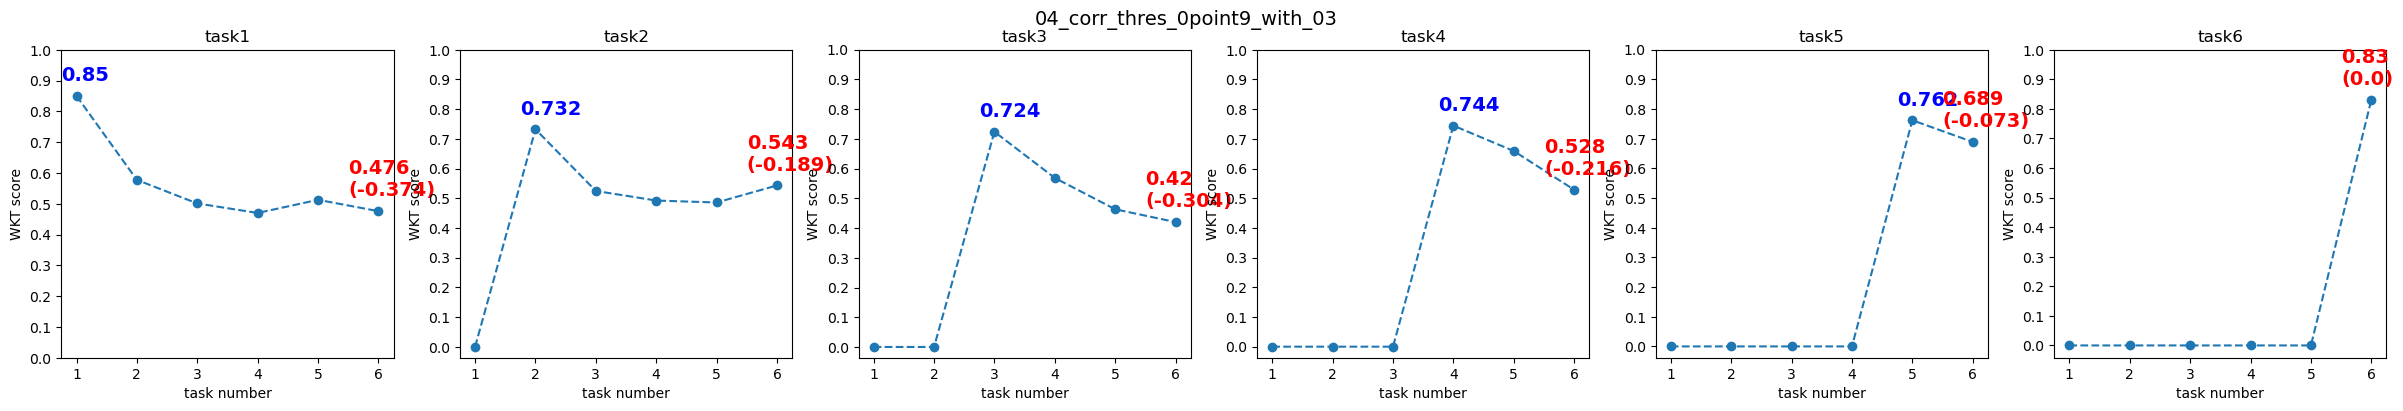

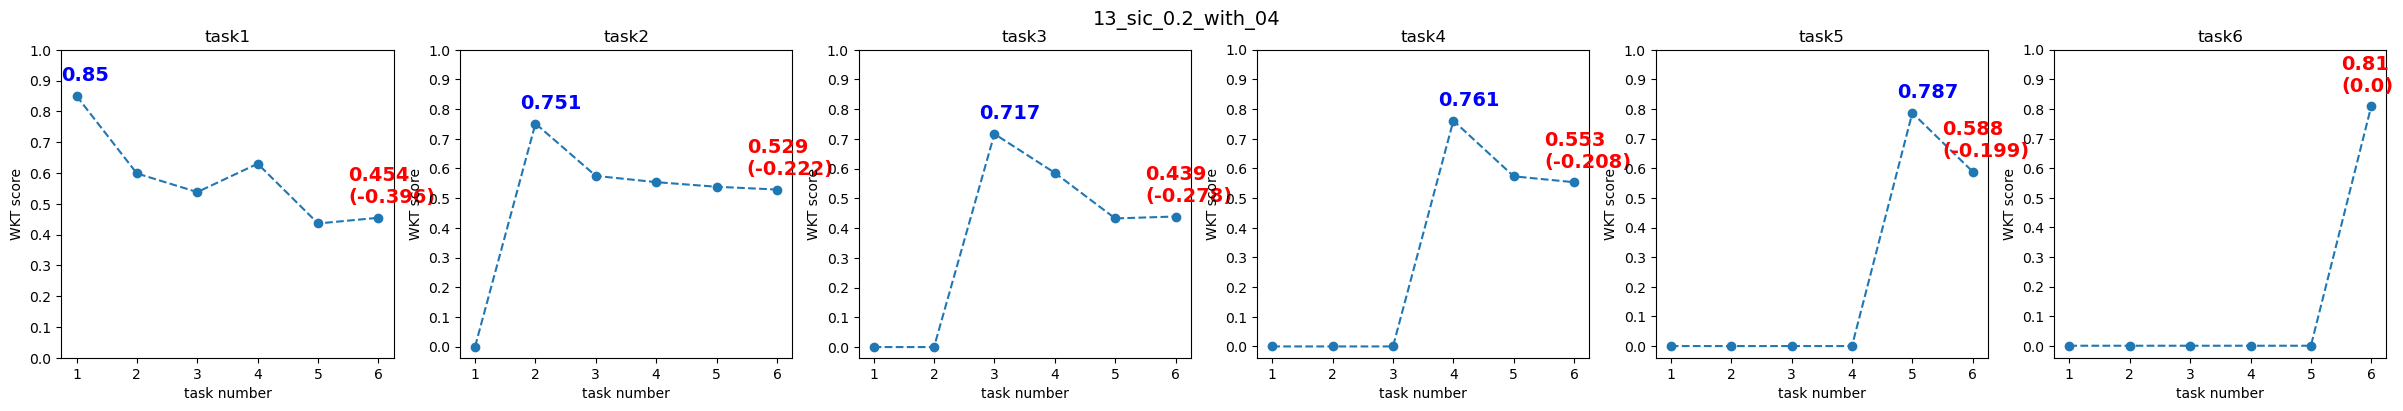

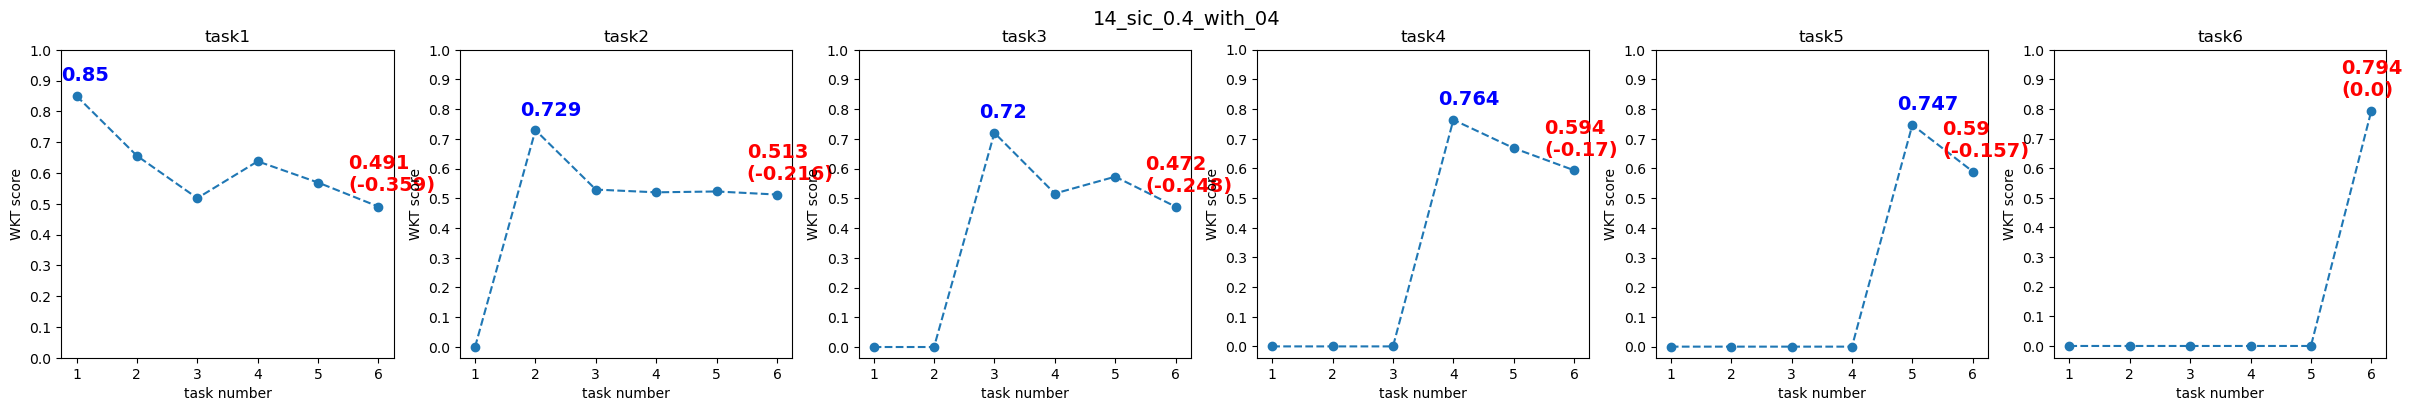

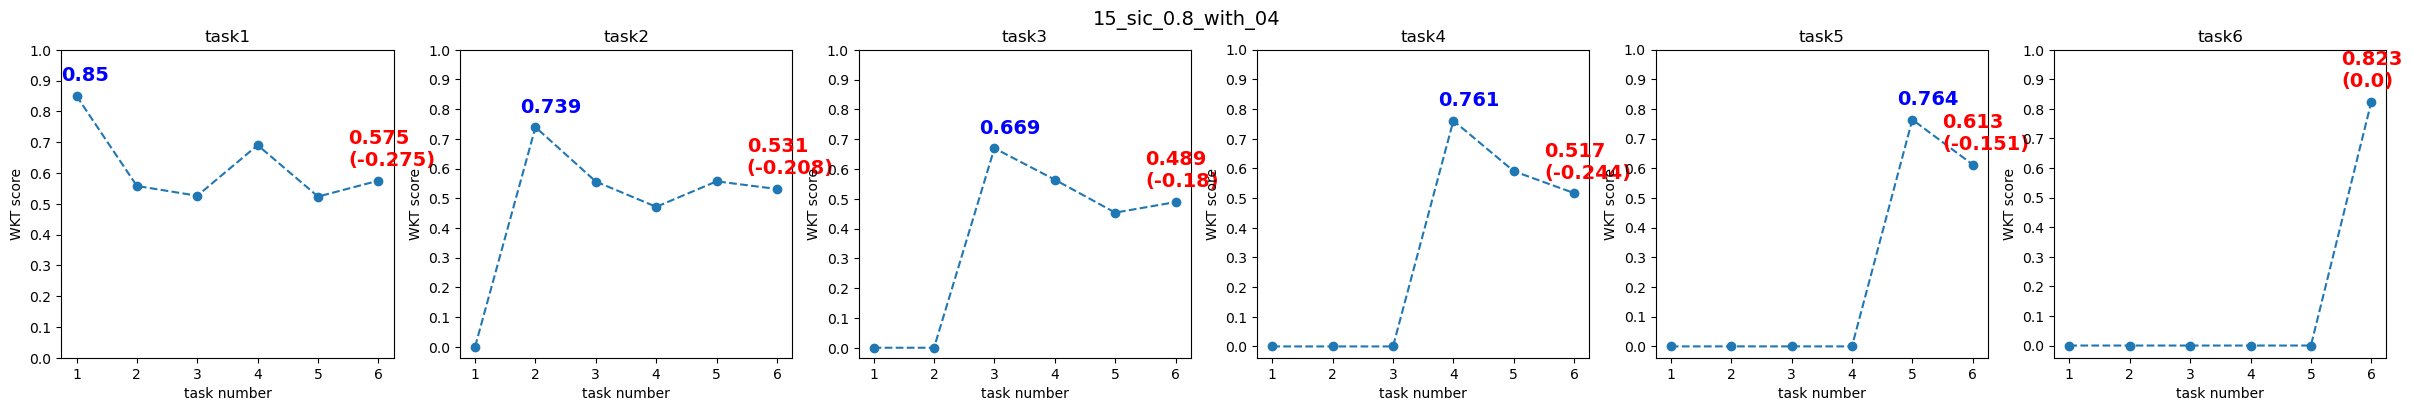

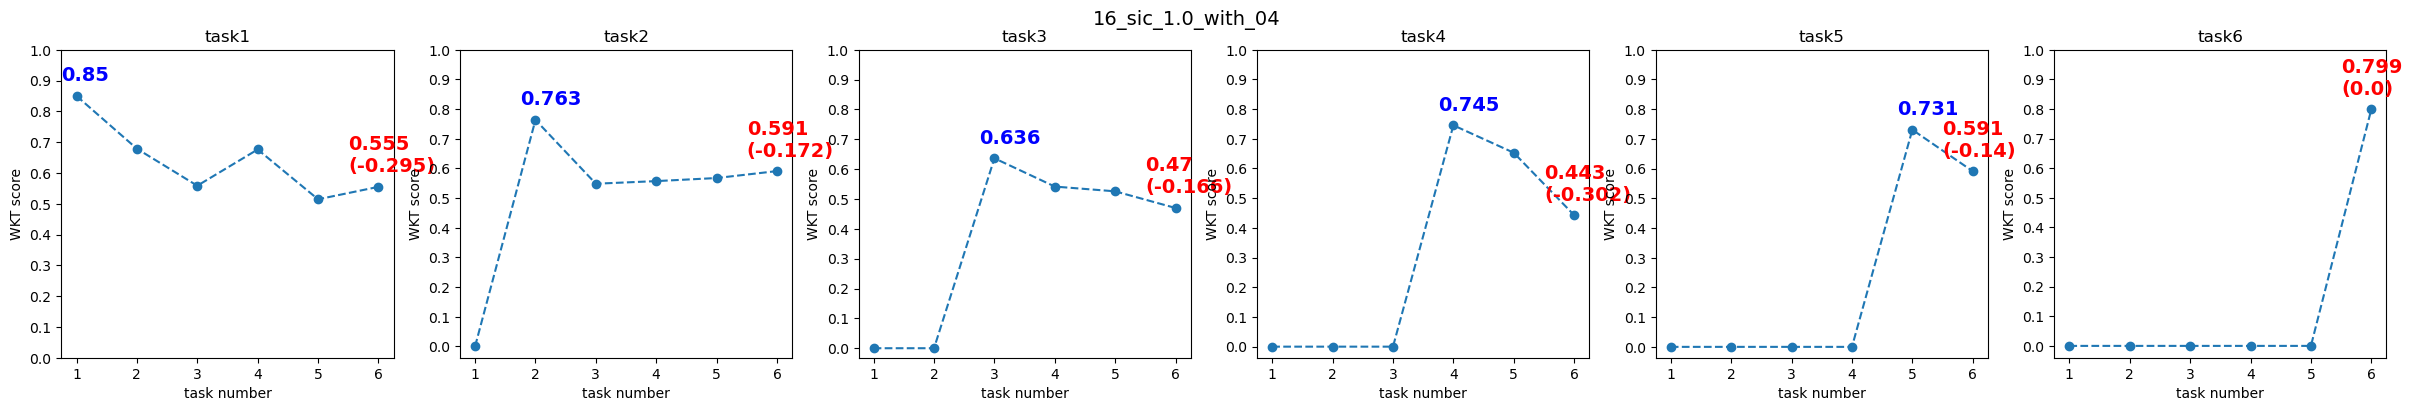

In [8]:
si_df = pd.concat([df[18:24], df[72:96]])
for i in range(0, len(si_df), 6):
    visualization(si_df[i:i + 6])

- surrogate loss의 반영 비율을 결정하는 `si_c` 파라미터에 따른 성능 차이를 비교해보았다.
- `si_c` 값을 높일수록 망각 현상이 완화되었고, 특히 `0.8`로 값을 설정했을 때 제일 좋은 성능을 보였다.

### `epsilon` 값 변경

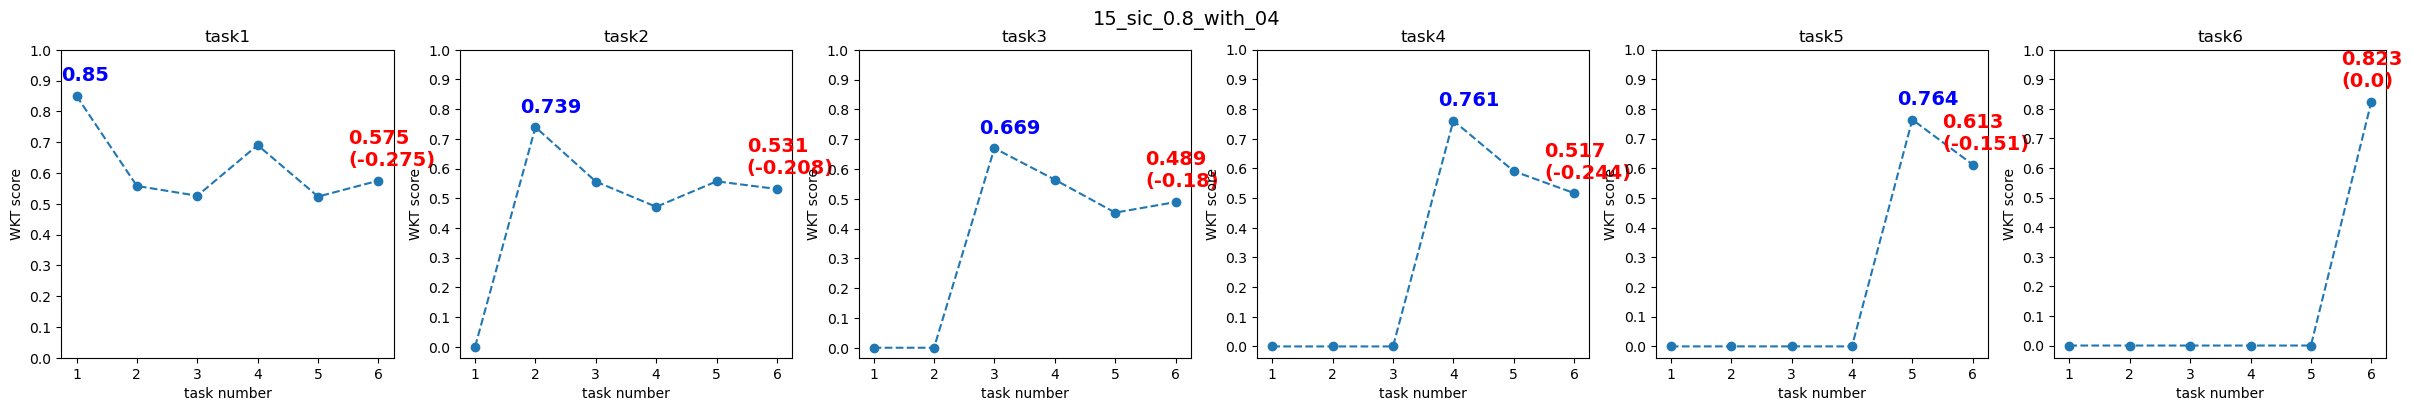

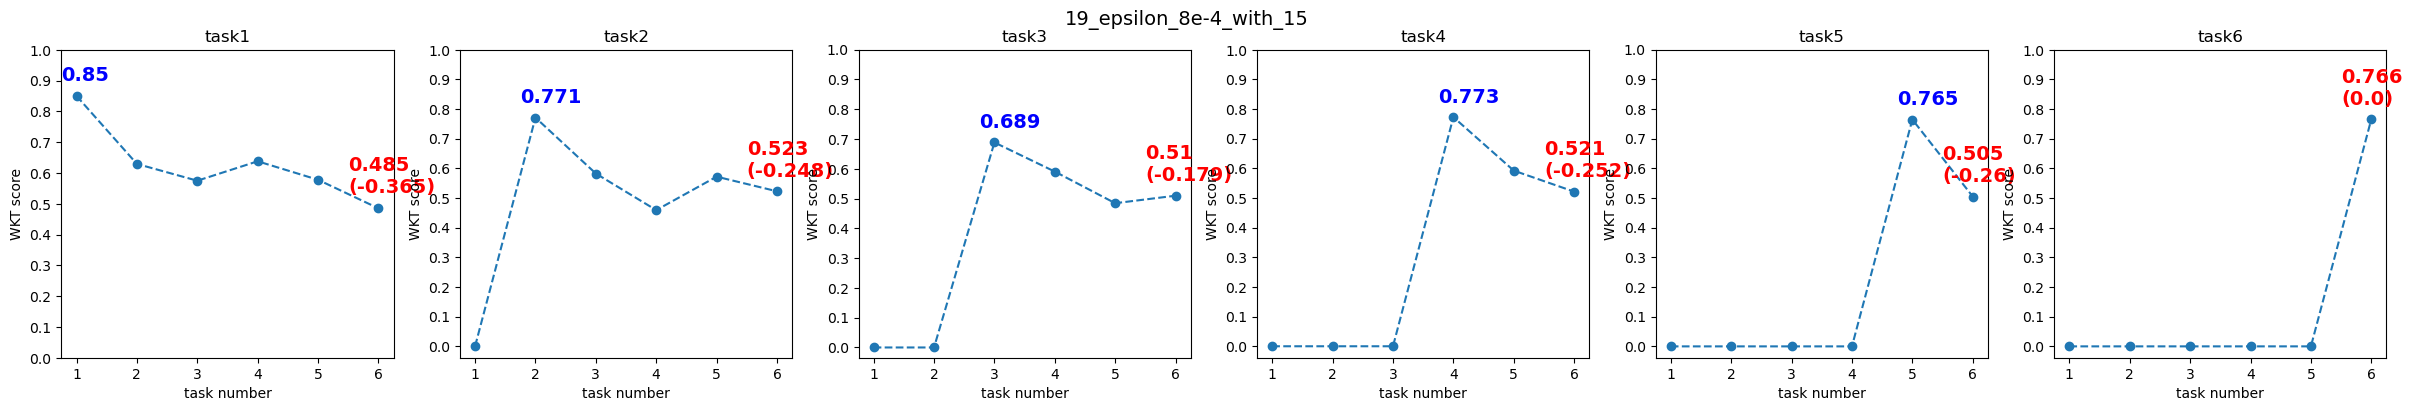

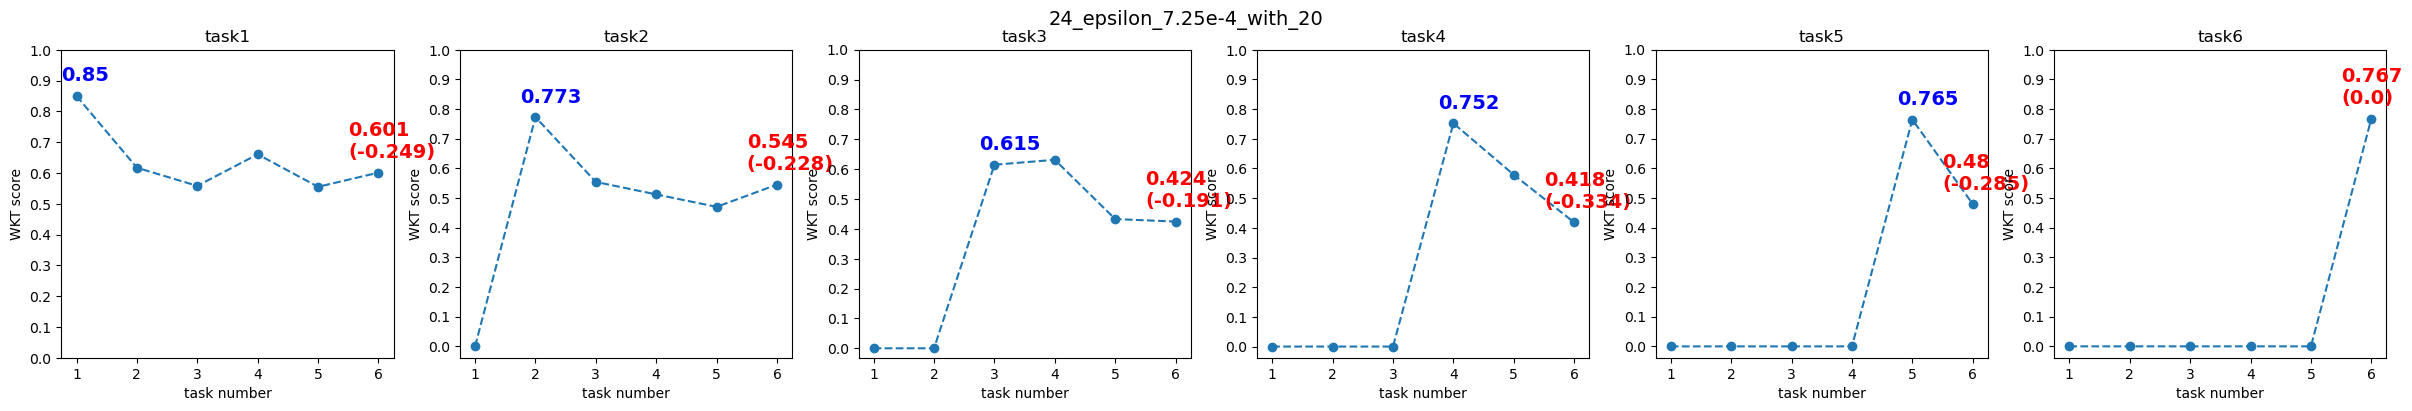

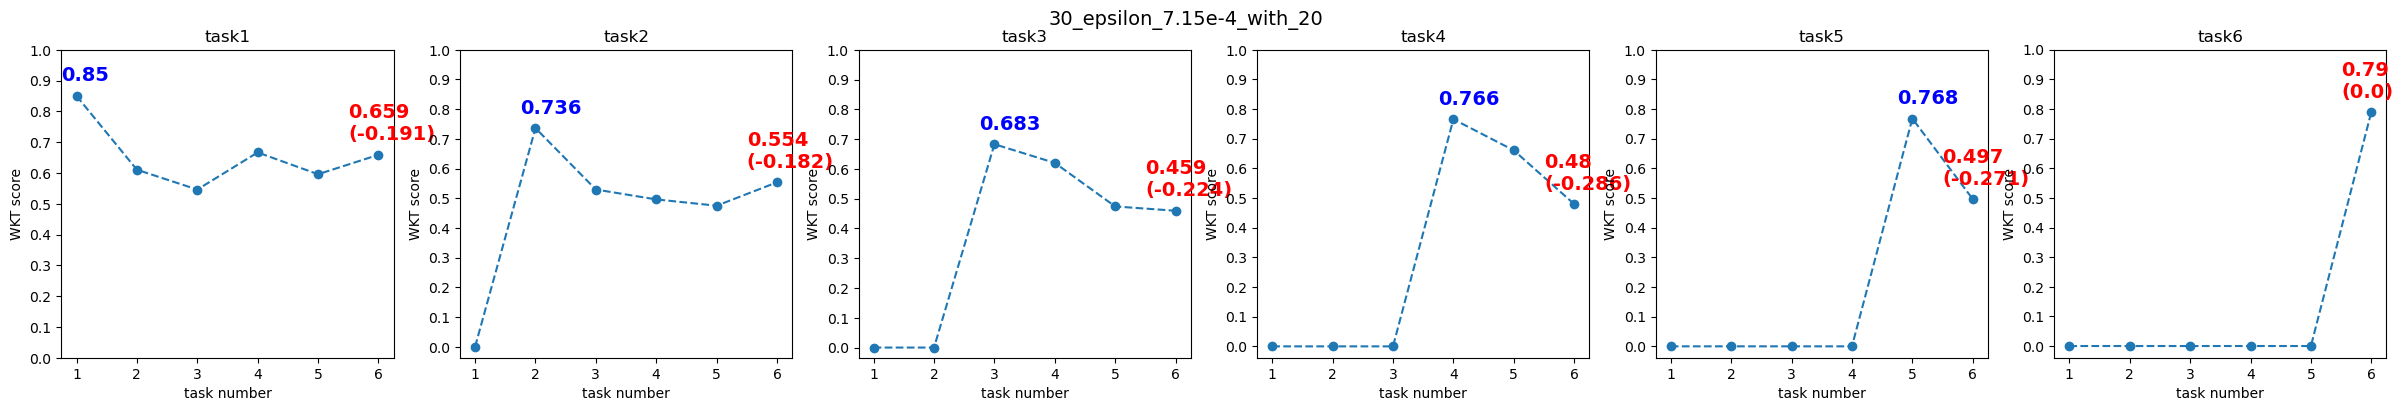

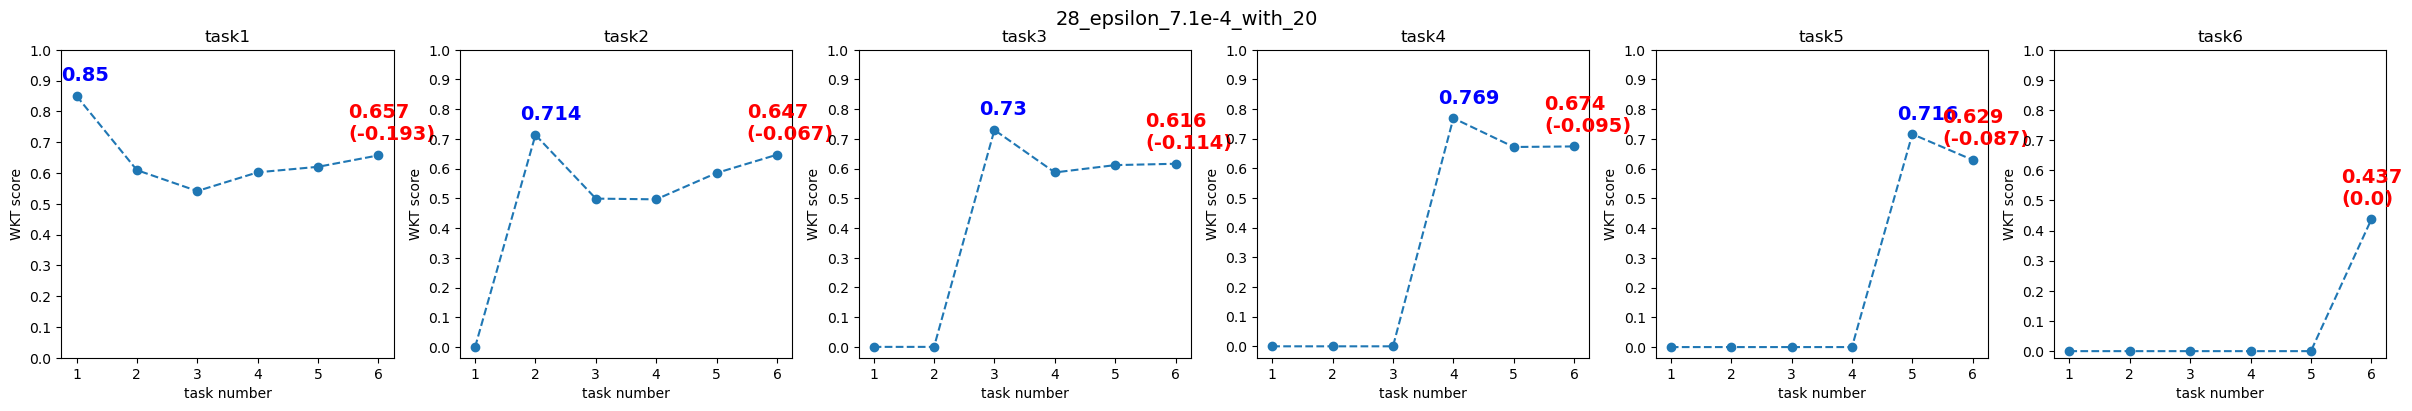

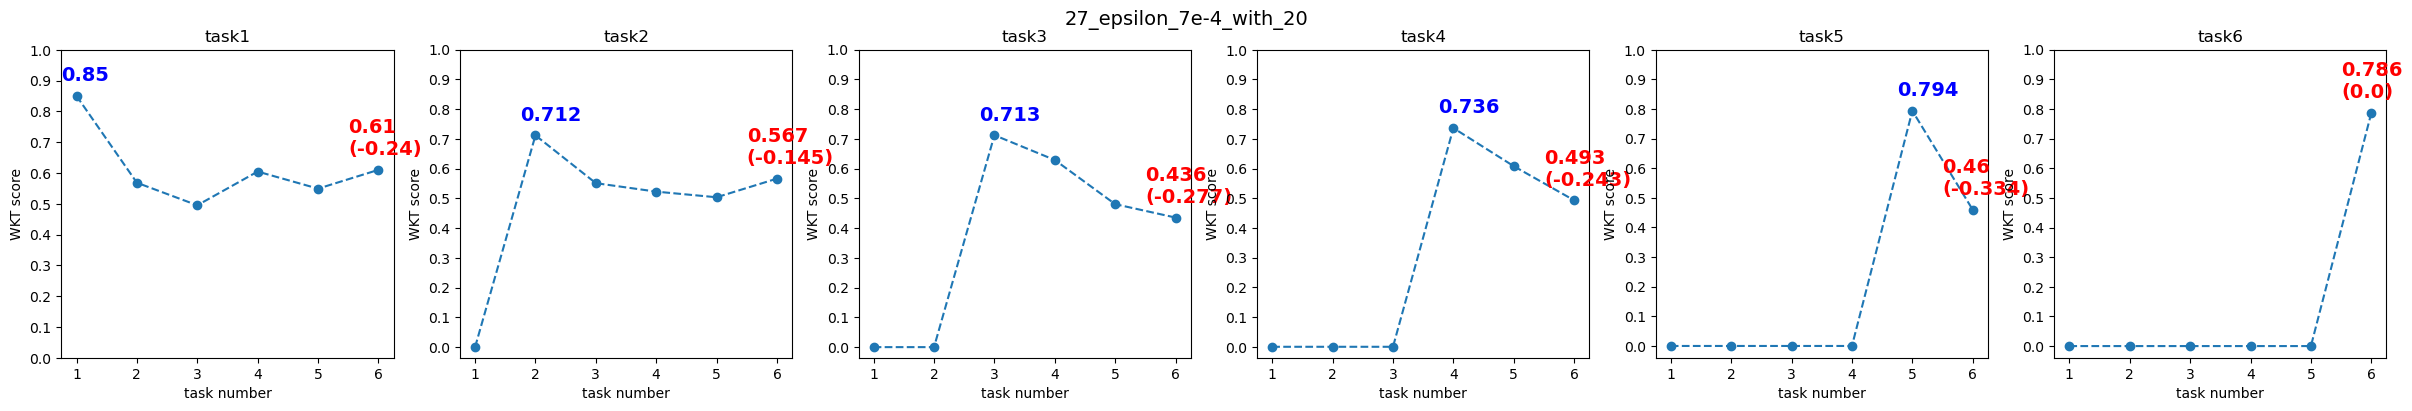

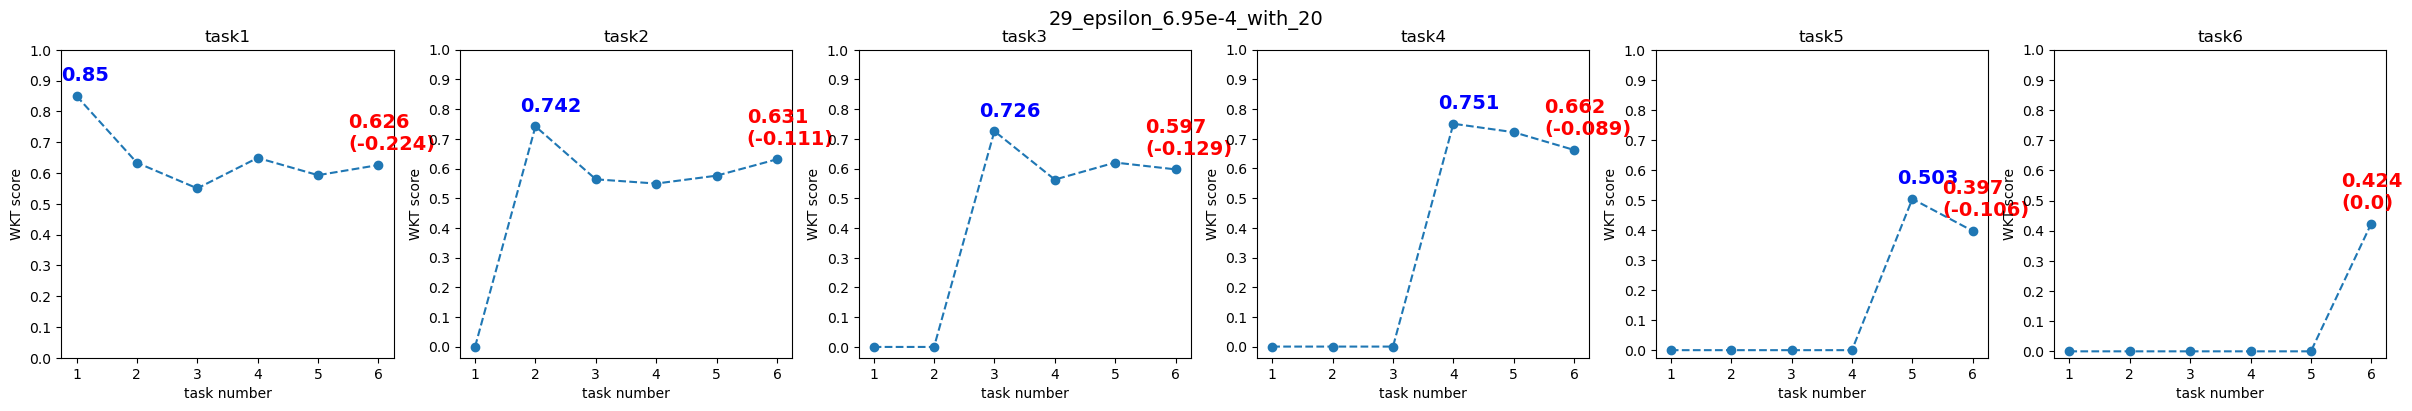

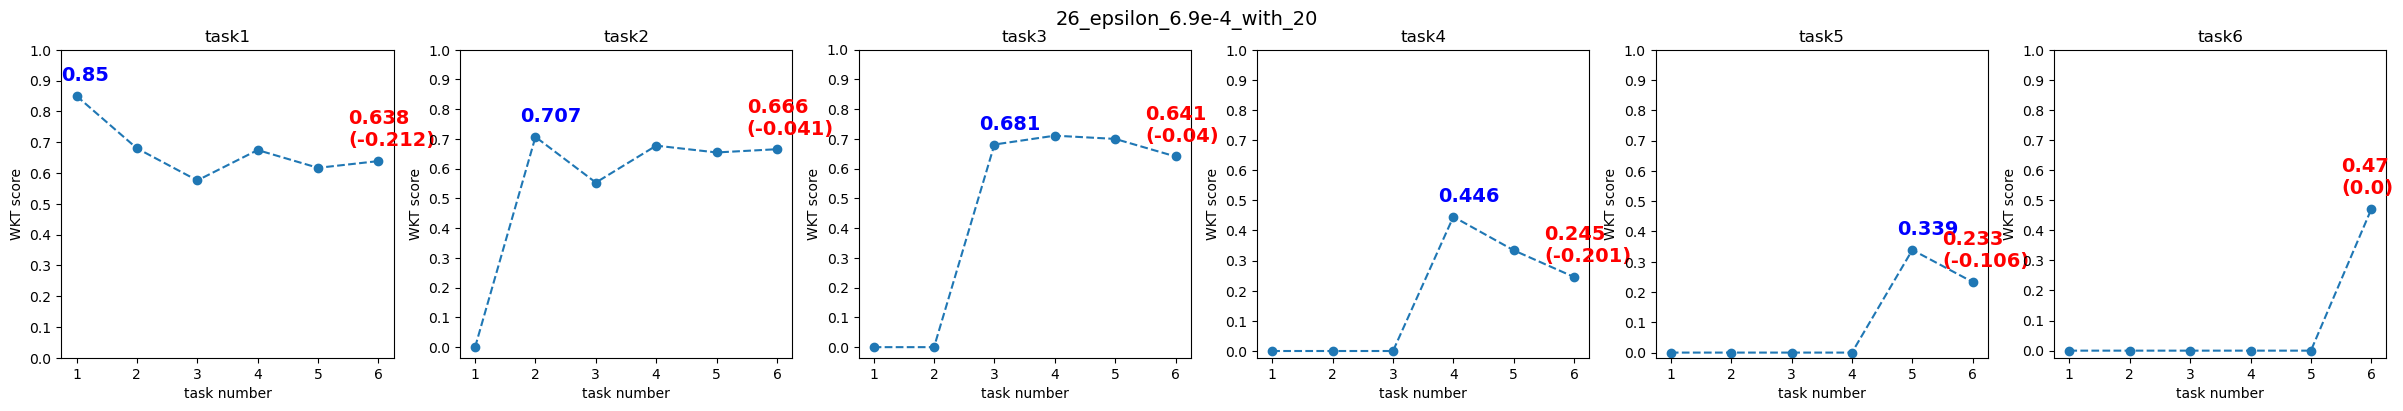

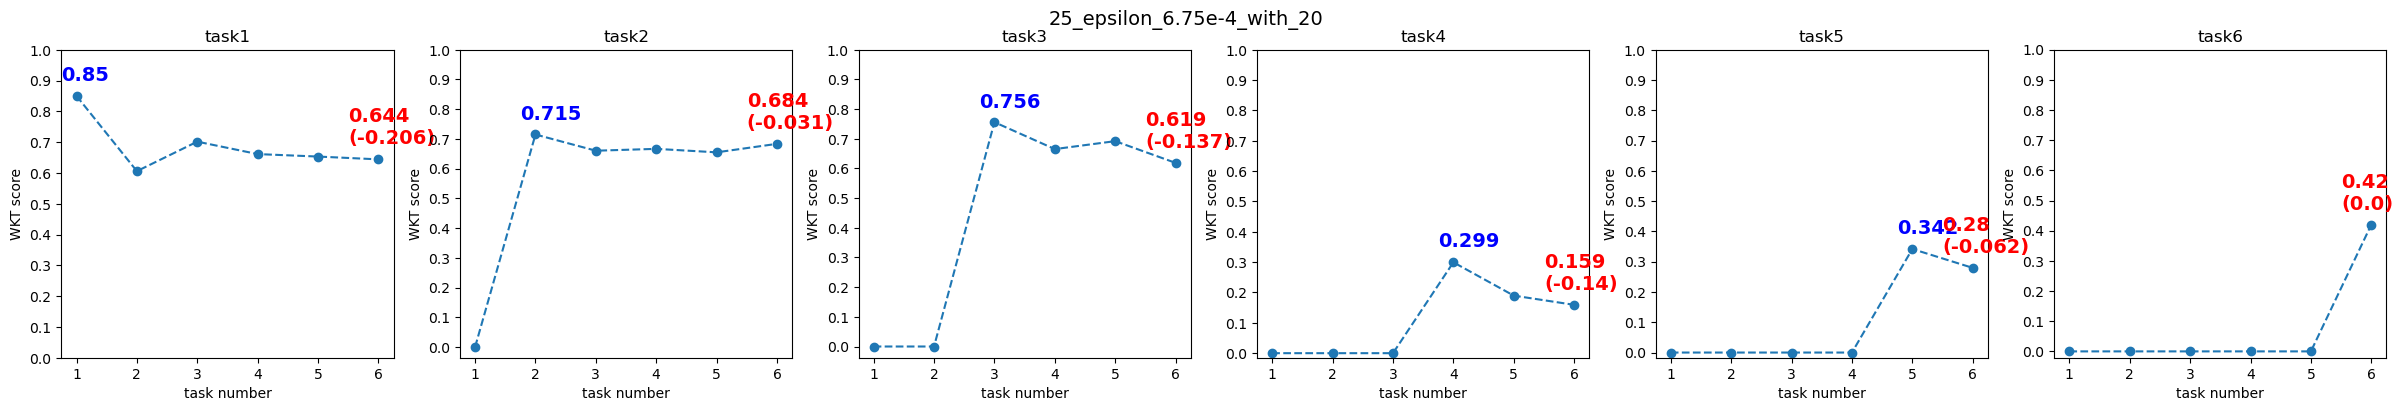

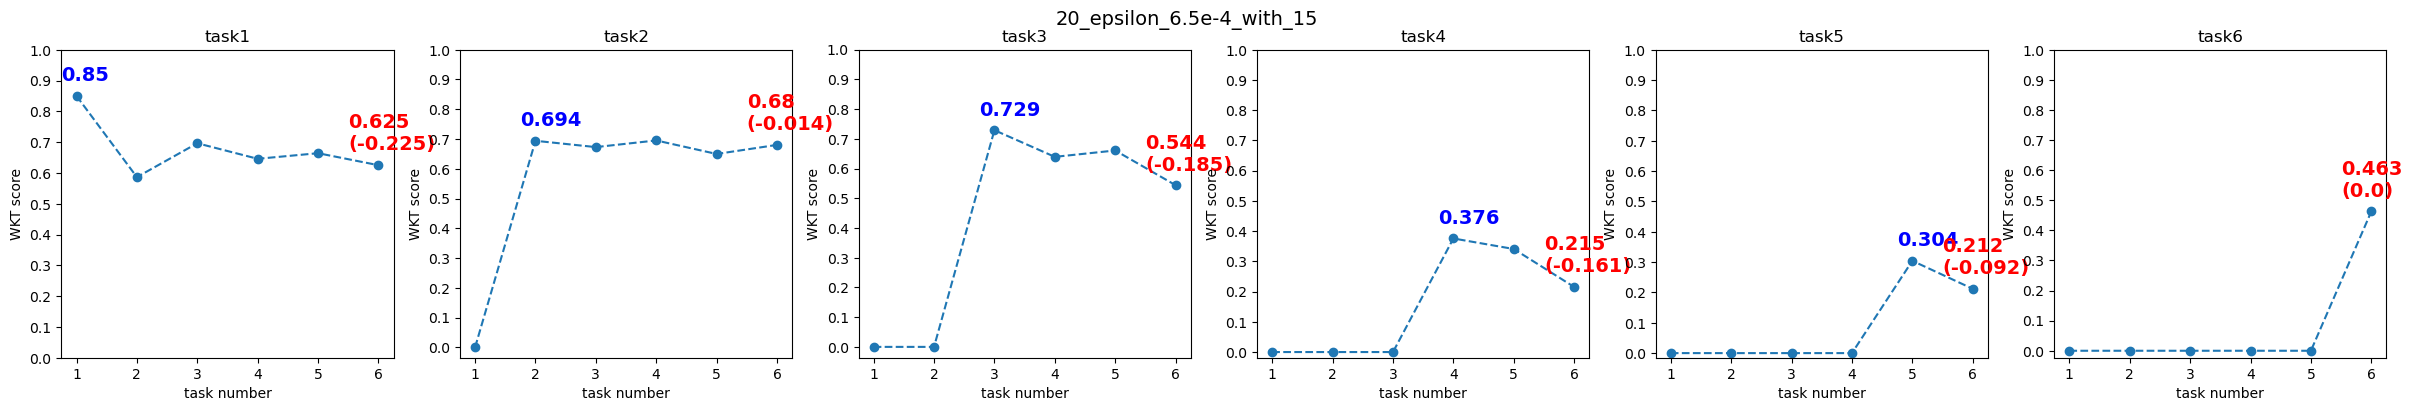

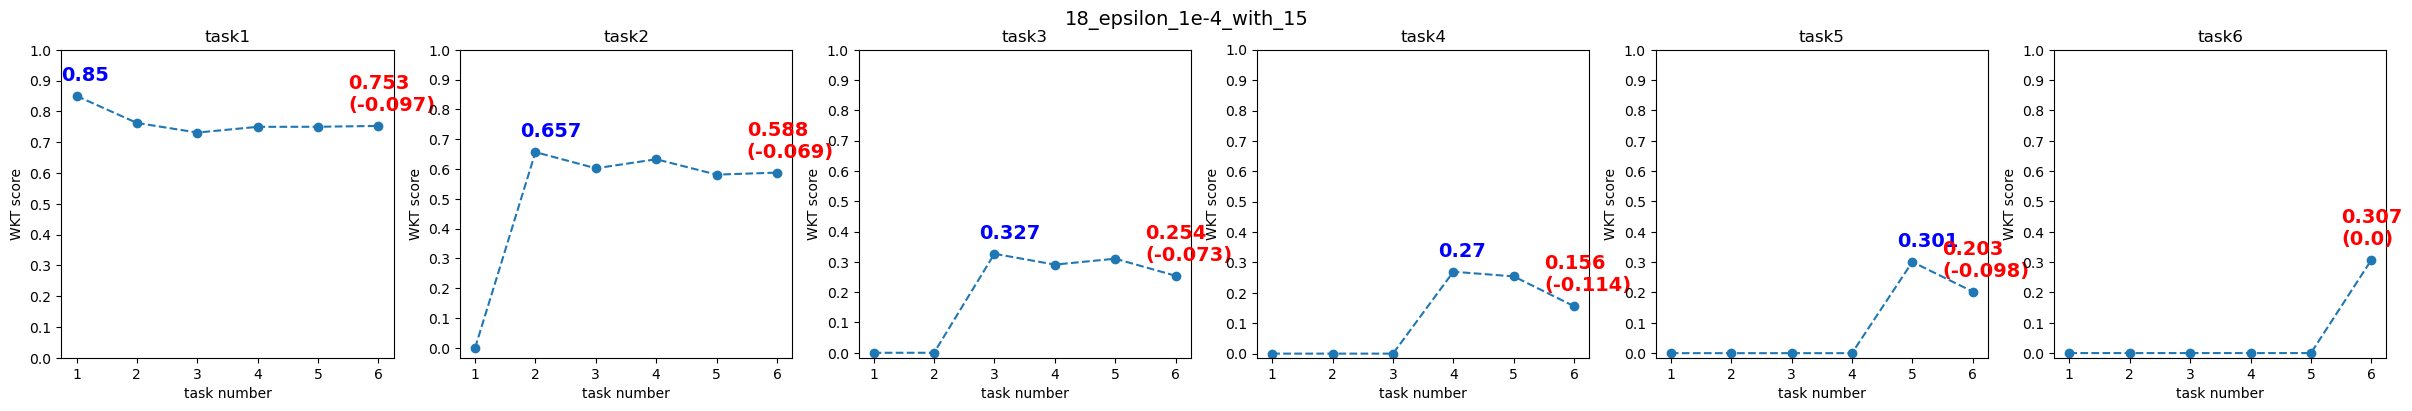

In [9]:
# epsilon 값이 큰 순서대로 배치
epsilon_df = pd.concat([df[84:90], # 1e-3
                        df[108:114], # 8e-4
                        df[138:144], df[174:180], df[162:168], df[156:162], # 7.25, 7.15, 7.1, 7.0e-4
                        df[168:174], df[150:156], df[144:150], df[114:120], # 6.95, 6.9, 6.75, 6.5e-4
                        df[102:108]]) # 1e-4
for i in range(0, len(epsilon_df), 6):
    visualization(epsilon_df[i:i + 6])

- 가장 좋은 성능을 기록했던 `si_c == 0.8` 세팅 후 `epsilon` 값 변경에 따른 추가 실험을 진행하였다.

$$
    \~{L}_{\mu} = L_{\mu} + c\sum_{_k}{\Omega^{\mu}_{k}(\~{\theta}_k - \theta_k)^{2}}
$$

- 위 수식은 synaptic intelligence 알고리즘의 loss function이다.
- c부터 시작하는 부분이 surrogate loss이다.

- c는 `si_c`를 의미하고, k는 파라미터의 인덱스를 의미하며, $\Omega^{\mu}_{k}$는 k번째 파라미터의 중요도를 나타내고, $\~{\theta}_k$는 이전 task를 학습한 파라미터(고정)를 의미하며, $\theta_k$는 현재 학습 중인 파라미터를 의미한다.

$$
    \Omega^{\mu}_{k} = \sum_{\nu<\mu}{\frac{\omega^{\nu}_{k}}{(\Delta^{\nu}_{k})^{2} + \epsilon}}
$$

$$
    \omega^{\mu}_{k} \equiv \int^{t^\mu}_{t^{\mu-1}}{g_k(\theta(t))\theta^{'}_k{t}dt}
$$

$$
    \Delta^{\nu}_{k} \equiv \theta_k(t^\nu) - \theta_k(t^{\nu - 1})
$$

- 현재 학습 중인 task를 $\mu$, 이전에 학습한 task를 $\nu$라고 할 때, $\omega^{\nu}_{k}$는 k번째 파라미터가 task $\nu$를 학습할 때 계산한 값으로, task $\nu$의 loss를 최소화하는 과정에서 k번째 파라미터가 변화한 양을 의미한다. 주의할 점은 수식에는 표기되어있지 않지만, $-$ 부호가 붙어야 한다. 대부분의 최적화 알고리즘이 gradient descent를 기반으로 하기에, 파라미터가 변화함에 따라 계산한 gradient에 $-$ 부호를 붙여줌으로써 역방향으로 파라미터가 변화하게 한다. 즉 중요도가 높은 파라미터가 변화했을 때, 원래 자리로 돌아갈 수 있도록 $-$ 부호를 곱해주는 것이라고 생각할 수 있다.
- $\Delta^{\nu}_{k}$는 task $\nu-1$과 task $\nu$를 학습하는 과정에서 파라미터가 변화한 양을 의미한다. 이동 거리로 생각할 수도 있다.

- $\epsilon$는 실제로 $\Omega$를 계산할 때 분모가 0이 되는 경우가 있어, 수치로 인한 에러를 방지하고자 사용하는 파라미터이다.

- 실험 결과를 보면 `epsilon` 값을 줄일수록 망각 현상이 완화됨과 동시에 새로운 task 학습이 어렵다는 사실을 알 수 있다.
- 이는 파라미터의 중요도를 나타내는 $\Omega$ 값에 `epsilon` 값의 영향이 크다는 얘기이고, 다시 말해 `epsilon` 값을 어떻게 설정하느냐에 따라 파라미터의 중요도가 결정된다고 얘기할 수 있다.
- `epsilon`의 영향이 크다는 것은 $\Delta^{\nu}_k$ 값이 작다는 것이고, 그럴 만도 한 것이 파라미터 값 자체는 극단적으로 변하지 않기 때문이다.

- `epsilon` 값을 세심하게 조정하며 실험해 볼 가치는 있다고 생각하지만,, 큰 성능 향상은 기대하기 어려울 것으로 보인다.

### 실험 20 기준으로 `si_c` 값 재변경

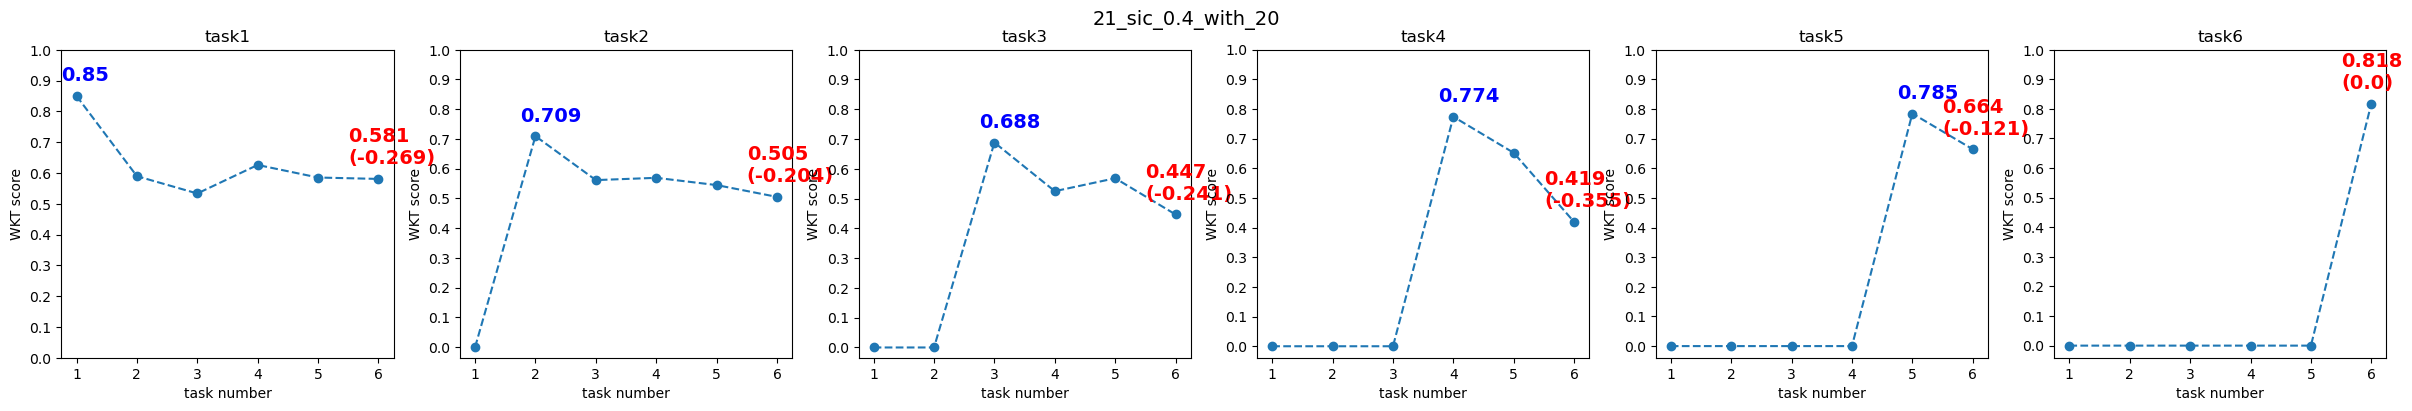

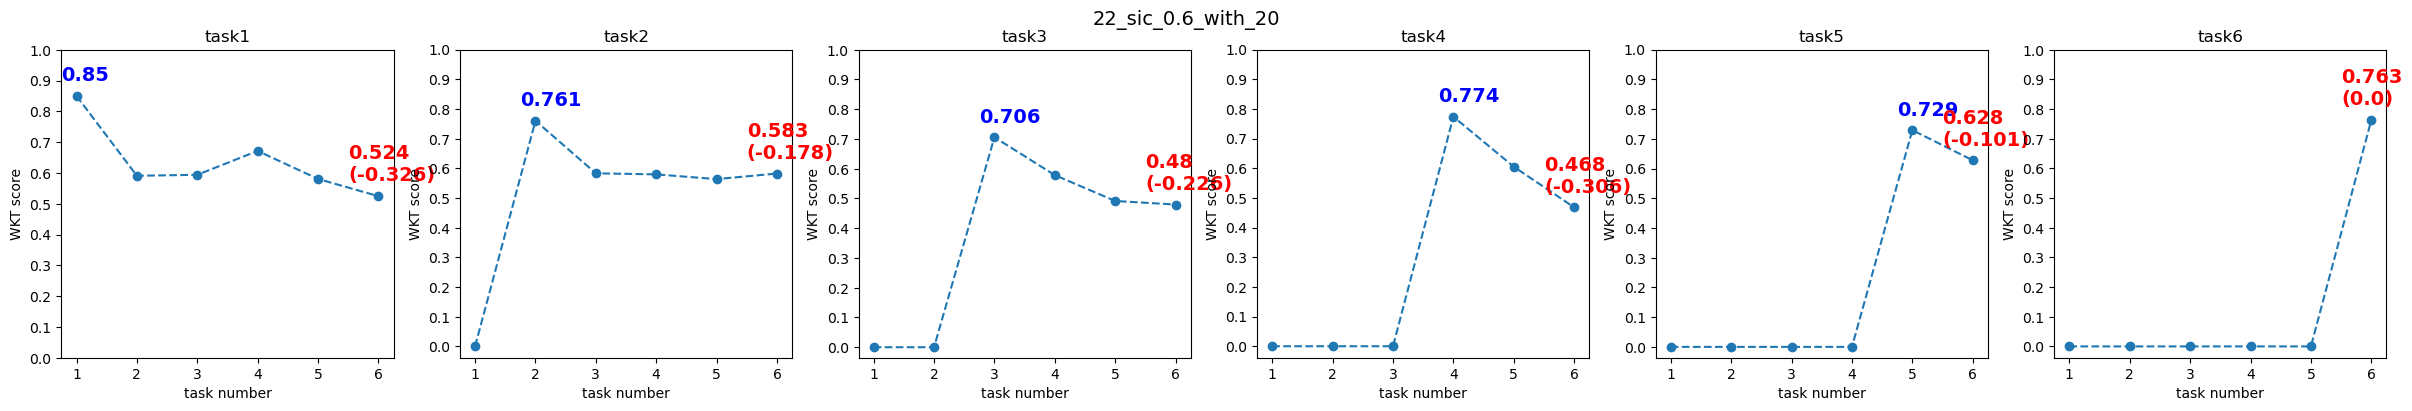

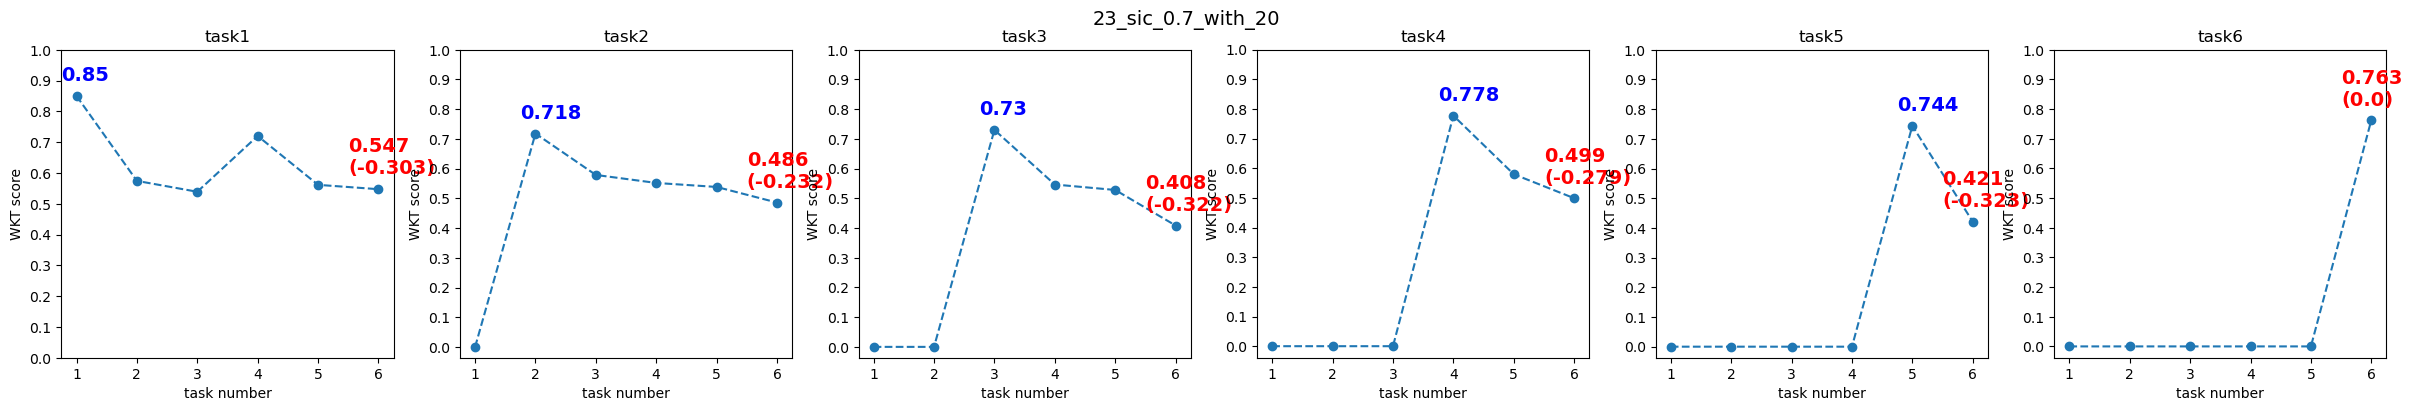

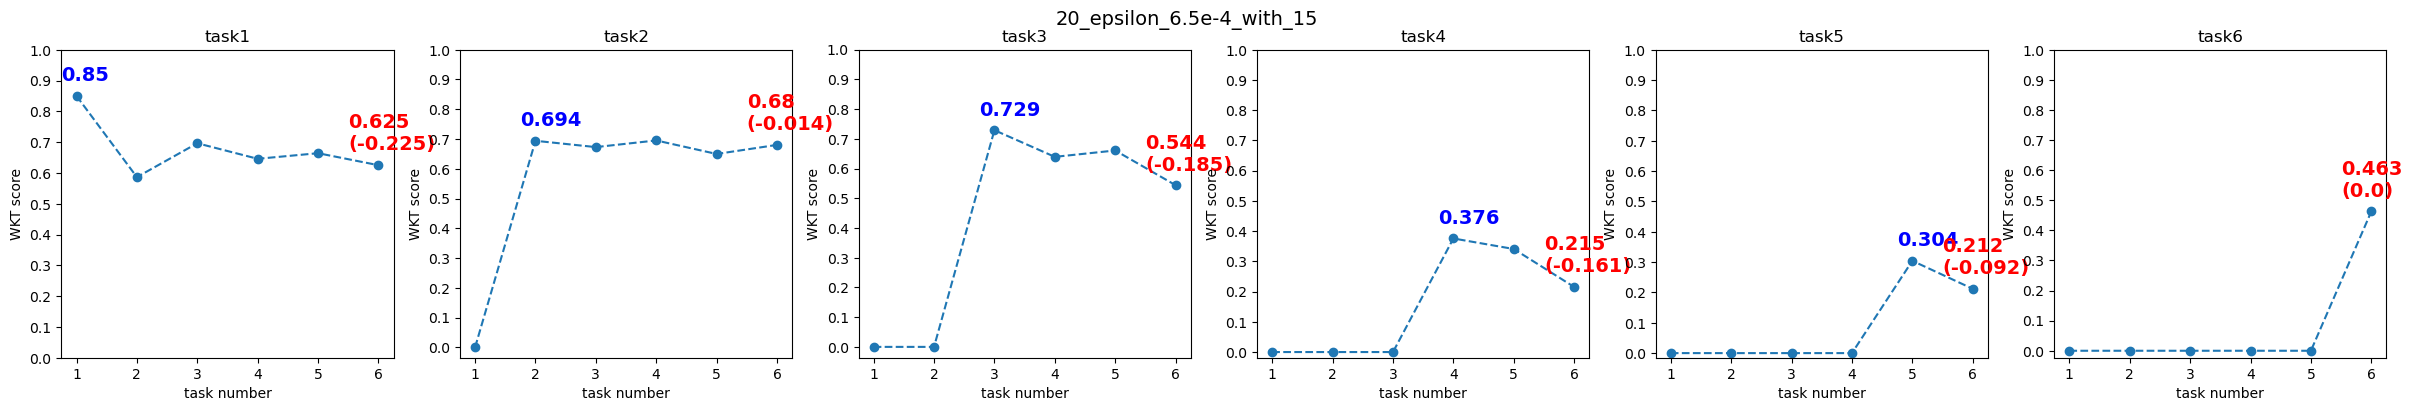

In [10]:
df_base_20 = pd.concat([df[120:138], df[114:120]])
for i in range(0, len(df_base_20), 6):
    visualization(df_base_20[i:i + 6])

-  `epsilon` 값으로 `6.5e-4`가 최적이라고 가정했을 때, `si_c` 값을 변경하여 실험함으로써 망각 현상 및 task 학습 능력을 관찰하고자 하였다.
- 모든 task를 학습할 수 있는 능력은 생겼으나, 망각 현상이 심해졌다.
- 결국 `si_c`와 `epsilon` 값의 범위를 정해두고, automl을 사용하는 것이 최적의 파라미터를 찾기 쉬울 듯 하다...

### 정리

- 규제화 기반의 방법론은 hyperparameter의 영향을 너무 크게 받는다.

### 시도해볼 것

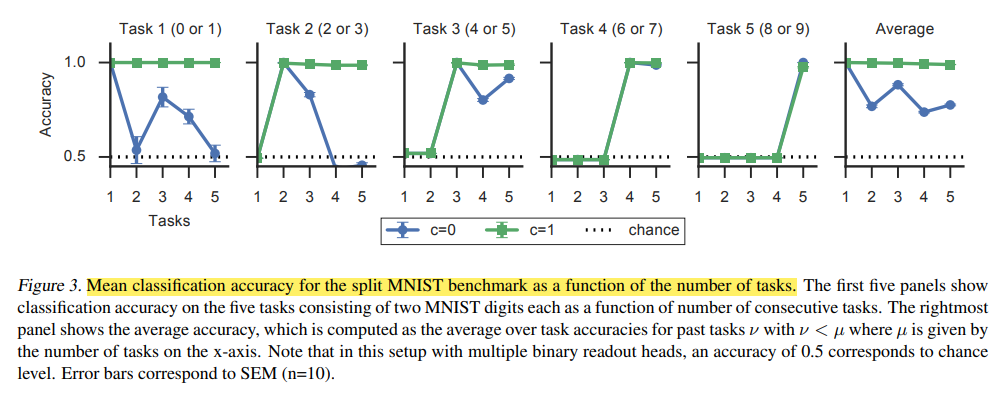

- Synaptic Intelligence 논문을 다시 읽어보면서 떠오른 생각인데, SI 알고리즘의 성능을 보여주고자 사용한 벤치마크 데이터셋이 MNIST 데이터셋이다.
- MNIST 데이터셋은 사실 아주 단순한 데이터로 구성되어 있으며, 최근에 만들어지는 데이터셋과 비교했을 때 학습 데이터와 평가 데이터 간의 차이가 그리 크지 않다고 판단할 수 있다. 따라서 Figure 3의 그래프들은 마냥 신뢰할 수 없다는 것이다.

- 현재는 validation wkt score만 측정하고 있는데, training wkt score를 측정하여 망각 정도를 관측해보면 어떨까 싶다.
- 만약 training wkt score에 대해서는 Figure 3과 같이 망각 현상 완화 및 준수한 task 학습 능력을 보인다면, training dataset과 validation dataset 간의 차이를 줄이는 방향으로 데이터 전처리를 진행해보는 것이 좋을 것 같다. 혹시나 validation dataset과 private test dataset이 유사한 방식이라면, 좋은 성능을 기대할 수 있을 것 같다.

- 그러나 training dataset에 대해서도 나쁜 성능을 보인다면 다른 알고리즘을 찾아야 할 것 같다.
- 다른 알고리즘을 찾을 때에는, 벤치마크 데이터셋이 복잡해야 하고, 규제화 기반 방법론보다 아키텍처? 기반 방법론을 찾아보는 것이 좋을 것 같다. (규제화 기반 방법론은 어떤 방법론이든 hyperparameter tuning 작업에 시간이 오래 걸릴 듯 하다)